# Introduction
这里是对论文**Hiding Image in Plain Sight: Deep Steganography**的复现
**Abstract:** Steganography is the practice of concealing a secret message within another, ordinary, message. Commonly, steganography is used to unobtrusively hide a small message within the noisy regions of a larger image. In this study, we attempt to place a full size color image within another image of the same size. Deep neural networks are simultaneously trained to create the hiding and revealing processes and are designed to specifically work as a pair. The system is trained on images drawn randomly from the ImageNet database, and works well on natural images from a wide variety of sources. Beyond demonstrating the successful application of deep learning to hiding images, we carefully examine how the result is achieved and explore extensions. Unlike many popular steganographic methods that encode the secret message within the least significant bits of the carrier image, our approach compresses and distributes the secret image's representation across all of the available bits.

In [ ]:
###Import###
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.engine.training import Model
from keras.layers import *
from keras.models import Model
import keras.utils as image
import keras.backend as K


import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
print(tqdm.__version__)


###常量###
data_dir="./data/tiny-imagenet-200"
train_dir=os.path.join(data_dir,"train")
test_dir=os.path.join(data_dir,"test")
image_shape=(64,64)

# Load Dataset
训练和测试的数据集选用的是Tiny ImageNet Visual Recognition Challenge
这里的训练集是从所有200类图片中随机抽出的一部分。

In [9]:
def load_dataset_tiny(num_images_per_class_train=10,num_images_test=500):
  x_train=[]# 训练集
  x_test=[]# 测试集

  #train set
  for c in os.listdir(train_dir):
    dir=os.path.join(train_dir,c,'images')
    #./data/tiny-imagenet-200/train/[class_name]/images
    images=os.listdir(dir)
    random.shuffle(images)#images文件夹中的图片随机置乱
    for img_name in images[0:num_images_per_class_train]:
      img=image.load_img(os.path.join(dir,img_name))
      x=image.img_to_array(img)
      x_train.append(x)
  random.shuffle(x_train)#x_train构建完成后再置乱一次

  #test set
  test_dir_=os.path.join(test_dir,'images')
  test_imgs=os.listdir(test_dir_)
  random.shuffle(test_imgs)
  for img_name in test_imgs[0:num_images_test]:
    img=image.load_img(os.path.join(test_dir_,img_name))
    x=image.img_to_array(img)
    x_test.append(x)

  return np.array(x_train),np.array(x_test)



In [10]:
x_train_orig,x_test_orig=load_dataset_tiny()
x_train=x_train_orig/255
x_test=x_test_orig/255

# Print statistics.
print ("Number of training examples = " + str(x_train.shape[0]))
print ("Number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


In [11]:
#把训练集分成两半，第一半作为secret image训练，第二半作为contain image训练
input_s=x_train[0:x_train.shape[0]//2]
input_c=x_train[x_train.shape[0]//2:]
print(input_s.shape[1:])

(64, 64, 3)


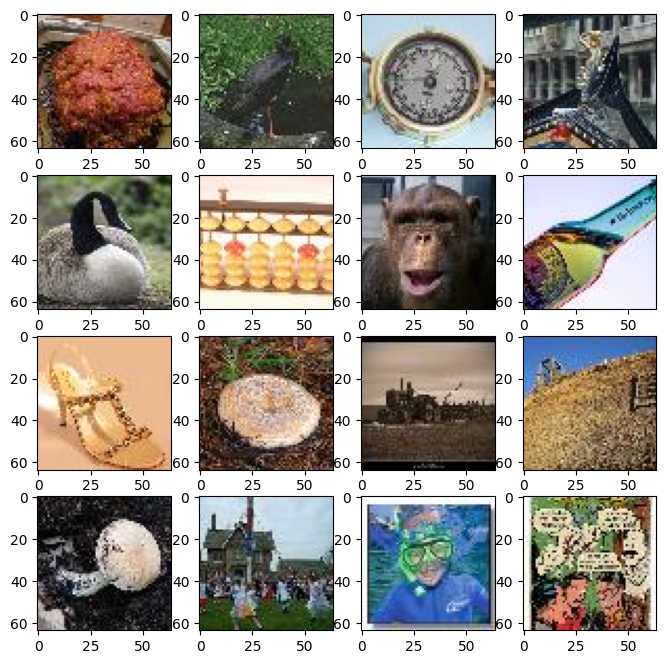

In [12]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(x_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[img_idx])
plt.show()

# Model
Preparation NetWork、
Hiding Network、
Reveal Network

Perp Network主要负责对秘密图像进行预处理，并学习将基于颜色的像素转化为更有用的图像特征，以便对图像进行简洁编码，提高嵌入效率。Hiding Network接收预处理网络的输出和Cover image作为输入，主要负责将秘密图像嵌入到载体图像中实现隐写。Reveal Network是接收方使用的网络，也是解码器。它仅接收生成的载体图像作为输入，作用是从载体图像中移除原始Cover image，以揭示出隐藏的秘密图像。

作者提到对Hiding Network采用了多种网络结构进行尝试，包括不同数量的隐藏层和卷积核尺寸。 **其中，表现最佳的结构是由5个卷积层组成的，每个卷积层有各50个不同大小的卷积核（滤波器），卷积核的大小分别为3x3，4x4和5x5。** 所以在代码实现中，我也采用了作者推荐的结构。

In [13]:
def make_encoder(input_size):
    input_s=Input(shape=(input_size))
    input_c=Input(shape=(input_size))

    #输入通道个数=卷积核通道个数
    #输出通道个数=卷积核个数
    ###Pre Network
    ###比如x3这里的卷积核维度是3*3*3*50
    x3 = Conv2D(50,(3,3),strides=(1,1),padding='same',activation='relu',name='conv_prep0_3x3')(input_s)
    x4 = Conv2D(10,(4,4),strides=(1,1),padding='same',activation='relu',name='conv_prep0_4x4')(input_s)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_s)
    x=concatenate([x3,x4,x5])
    #将不同尺寸的特征图组合在一起，提取更加丰富的特征表示

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    x = concatenate([input_c, x])

    ###Hidden Network
    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_hid4_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_image = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='relu', name='output')(x)

    return Model(inputs=[input_s, input_c], outputs=output_image, name='Encoder')

def make_decoder(input_size):
    ###Reveal Network
    reveal_input = Input(shape=(input_size))
    input_with_noise = GaussianNoise(0.01, name='container_noise')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Se = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='relu', name='output_S')(x)

    return Model(inputs=reveal_input, outputs=output_Se, name='Decoder')

# Loss and Back Propagation
![image.png](./md-image/loss.png)

网络的后向传播方式如下图所示。首先，loss中的第一项衡量了原始图像与嵌入秘密信息后图像之间的差异。这个误差项的权重不会影响到接收载体图像并提取秘密图像的揭示网络（Reveal Network）的训练。第二个误差项是β||s – s’||，它衡量了秘密图像与提取出的秘密图像之间的差异。这个误差项的权重会影响到所有网络的训练，包括准备网络、隐藏网络和揭示网络。通过调整权衡因子β的值，可以控制这个误差项对各个网络的训练的影响程度。我觉得这样做的目的是让Prep network和Hiding network也能学习到秘密图像提取的信息，保证提取的效果，同时第一项不参加Reveal Network的训练可能是因为害怕将网络方向弄反。

![image.png](./md-image/bp.png)

In [14]:
bata=1.0
def rev_loss(s_true,s_pred):
    return  bata*K.sum(K.square(s_true-s_pred))
def full_loss(y_true,y_pred):
    ###loss:|c-c'|^2+beta*|s-s'|^2
    s_true, c_true=y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred=y_pred[...,0:3], y_pred[...,3:6]
    s_loss=rev_loss(s_true,s_pred)
    c_loss=K.sum(K.square(c_true-c_pred))
    return s_loss+c_loss

def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False#冻结参数

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

print(input_s.shape[0])

encoder_model, reveal_model, autoencoder_model=make_model(input_s.shape[1:])

1000


2023-06-17 20:24:38.282605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 20:24:38.321508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 20:24:38.321810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 20:24:38.323243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

# Training
定义训练轮数（NB_EPOCHS）为1000，每一个Batch的大小为32。

在每个批次训练过程中，autoencoder_model通过计算并更新损失函数来逐步优化模型的参数。同时，reveal_model也就是Reveal Network也使用encoder_model的输出结果进行训练，并根据反向损失函数（reveal_model.train_on_batch()）进行参数更新。为了控制模型的训练，学习率在每个批次训练后进行更新。

每个训练轮结束后，保存autoencoder_model、encoder_model和reveal_model的权重至hdf5文件，以便后续的使用和评估。同时，记录自动编码器的损失值，定义进度条tdqm，在每个epoch训练完后展示平均的各项损失。

下面是1000轮训练的输出，略长^_^


In [15]:
def lr_schedule(epoch_idx):#学习率的调节函数
    if epoch_idx<200:
        return 0.001
    elif epoch_idx<400:
        return 0.0003
    elif epoch_idx<600:
        return 0.0001
    else:
        return 0.00003

NB_EPOCHS=1000#一共训练1000个epoch
BATCH_SIZE=32#batch大小32
m=input_s.shape[0]
loss_history=[]

for epoch in tqdm(range(NB_EPOCHS), unit='epoch',mininterval=0):
    np.random.shuffle(input_s)
    np.random.shuffle(input_c)

    ae_loss_list = []
    rev_loss_list = []

    for idx in range(0, input_s.shape[0], BATCH_SIZE):
        batch_S = input_s[idx:min(idx + BATCH_SIZE, m)]#秘密图像
        batch_c = input_c[idx:min(idx + BATCH_SIZE, m)]#cover image

        c_prime = encoder_model.predict([batch_S, batch_c])#encoder_model的输出结果作为reveal_model的输入
        ae_loss_list.append(autoencoder_model.train_on_batch(x=[batch_S, batch_c], y=np.concatenate((batch_S, batch_c), axis=3)))
        rev_loss_list.append(reveal_model.train_on_batch(x=c_prime, y=batch_S))#train_on_batch

        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))#更新学习率
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))

    autoencoder_model.save_weights('./autoencoder_model.hdf5')
    encoder_model.save_weights('./encoder_model.hdf5')
    reveal_model.save_weights('./reveal_model.hdf5')#每个epoch结束记得保存模型，防止网络中断就白train了www
    loss_history.append(np.mean(ae_loss_list))

    # 更新进度条描述
    tqdm.write('Epoch {} | Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, np.mean(ae_loss_list), np.mean(rev_loss_list)))


  0%|          | 0/1000 [00:00<?, ?epoch/s]2023-06-17 20:24:43.499630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-06-17 20:24:44.588156: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-06-17 20:24:44.588237: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-06-17 20:24:44.588350: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


2023-06-17 20:24:49.303724: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb313d16d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-17 20:24:49.303820: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-17 20:24:49.327083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-17 20:24:49.510048: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 218ms/step


  0%|          | 1/1000 [00:21<5:53:05, 21.21s/epoch]

Epoch 1 | Loss AE  100721.25 | Loss Rev   60306.41
1/1 [==============================] - 0s 21ms/step


  0%|          | 2/1000 [00:25<3:05:42, 11.16s/epoch]

Epoch 2 | Loss AE   37893.38 | Loss Rev   21473.80
1/1 [==============================] - 0s 23ms/step


  0%|          | 3/1000 [00:29<2:12:20,  7.96s/epoch]

Epoch 3 | Loss AE   24536.84 | Loss Rev   14699.78
1/1 [==============================] - 0s 20ms/step


  0%|          | 4/1000 [00:33<1:47:49,  6.50s/epoch]

Epoch 4 | Loss AE   21570.12 | Loss Rev   13678.26
1/1 [==============================] - 0s 22ms/step


  0%|          | 5/1000 [00:37<1:33:56,  5.67s/epoch]

Epoch 5 | Loss AE   15839.47 | Loss Rev    9609.01
1/1 [==============================] - 0s 22ms/step


  1%|          | 6/1000 [00:42<1:25:45,  5.18s/epoch]

Epoch 6 | Loss AE   15053.42 | Loss Rev    9284.30
1/1 [==============================] - 0s 22ms/step


  1%|          | 7/1000 [00:46<1:20:50,  4.88s/epoch]

Epoch 7 | Loss AE   13440.36 | Loss Rev    8267.09
1/1 [==============================] - 0s 22ms/step


  1%|          | 8/1000 [00:50<1:17:17,  4.68s/epoch]

Epoch 8 | Loss AE   15924.06 | Loss Rev   10025.74
1/1 [==============================] - 0s 22ms/step


  1%|          | 9/1000 [00:54<1:15:02,  4.54s/epoch]

Epoch 9 | Loss AE   11945.46 | Loss Rev    7195.70
1/1 [==============================] - 0s 25ms/step


  1%|          | 10/1000 [00:59<1:13:23,  4.45s/epoch]

Epoch 10 | Loss AE   14110.40 | Loss Rev    9057.73
1/1 [==============================] - 0s 21ms/step


  1%|          | 11/1000 [01:03<1:12:29,  4.40s/epoch]

Epoch 11 | Loss AE   10975.50 | Loss Rev    6588.13
1/1 [==============================] - 0s 23ms/step


  1%|          | 12/1000 [01:07<1:11:01,  4.31s/epoch]

Epoch 12 | Loss AE   10646.33 | Loss Rev    6342.86
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 13/1000 [01:11<1:09:54,  4.25s/epoch]

Epoch 13 | Loss AE    9501.62 | Loss Rev    5264.55
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 14/1000 [01:16<1:11:49,  4.37s/epoch]

Epoch 14 | Loss AE    9881.02 | Loss Rev    5574.43
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 15/1000 [01:20<1:11:12,  4.34s/epoch]

Epoch 15 | Loss AE    8875.36 | Loss Rev    4863.39
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 16/1000 [01:24<1:10:00,  4.27s/epoch]

Epoch 16 | Loss AE    8608.96 | Loss Rev    4655.87
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 17/1000 [01:28<1:09:19,  4.23s/epoch]

Epoch 17 | Loss AE   11035.84 | Loss Rev    6080.01
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 18/1000 [01:32<1:08:35,  4.19s/epoch]

Epoch 18 | Loss AE    7793.39 | Loss Rev    4052.61
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 19/1000 [01:37<1:08:24,  4.18s/epoch]

Epoch 19 | Loss AE    8742.57 | Loss Rev    4906.04
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 20/1000 [01:41<1:08:11,  4.17s/epoch]

Epoch 20 | Loss AE    7466.52 | Loss Rev    3829.39
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 21/1000 [01:45<1:08:10,  4.18s/epoch]

Epoch 21 | Loss AE    7339.86 | Loss Rev    3668.25
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 22/1000 [01:49<1:08:28,  4.20s/epoch]

Epoch 22 | Loss AE    7413.31 | Loss Rev    3977.72
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 23/1000 [01:53<1:08:15,  4.19s/epoch]

Epoch 23 | Loss AE    8291.40 | Loss Rev    4401.81
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 24/1000 [01:58<1:08:02,  4.18s/epoch]

Epoch 24 | Loss AE    6688.05 | Loss Rev    3470.22
1/1 [==============================] - 0s 23ms/step


  2%|▎         | 25/1000 [02:02<1:07:49,  4.17s/epoch]

Epoch 25 | Loss AE    6656.95 | Loss Rev    3493.76
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 26/1000 [02:06<1:07:39,  4.17s/epoch]

Epoch 26 | Loss AE    6731.41 | Loss Rev    3442.74
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 27/1000 [02:10<1:07:36,  4.17s/epoch]

Epoch 27 | Loss AE   19779.75 | Loss Rev   12448.06
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 28/1000 [02:14<1:07:36,  4.17s/epoch]

Epoch 28 | Loss AE   10324.76 | Loss Rev    5832.69
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 29/1000 [02:18<1:07:50,  4.19s/epoch]

Epoch 29 | Loss AE    8513.17 | Loss Rev    5677.20
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 30/1000 [02:23<1:08:12,  4.22s/epoch]

Epoch 30 | Loss AE    8041.10 | Loss Rev    5513.28
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 31/1000 [02:27<1:08:32,  4.24s/epoch]

Epoch 31 | Loss AE    6790.96 | Loss Rev    4168.17
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 32/1000 [02:31<1:08:24,  4.24s/epoch]

Epoch 32 | Loss AE    6636.88 | Loss Rev    4008.74
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 33/1000 [02:36<1:09:00,  4.28s/epoch]

Epoch 33 | Loss AE    6320.50 | Loss Rev    3607.29
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 34/1000 [02:40<1:09:04,  4.29s/epoch]

Epoch 34 | Loss AE    8204.38 | Loss Rev    5338.06
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 35/1000 [02:44<1:10:05,  4.36s/epoch]

Epoch 35 | Loss AE    7064.36 | Loss Rev    3816.49
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 36/1000 [02:49<1:10:39,  4.40s/epoch]

Epoch 36 | Loss AE    6075.28 | Loss Rev    3603.32
1/1 [==============================] - 0s 21ms/step


  4%|▎         | 37/1000 [02:53<1:10:13,  4.38s/epoch]

Epoch 37 | Loss AE    5986.88 | Loss Rev    3593.54
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 38/1000 [02:57<1:09:27,  4.33s/epoch]

Epoch 38 | Loss AE    7335.06 | Loss Rev    4607.57
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 39/1000 [03:02<1:09:36,  4.35s/epoch]

Epoch 39 | Loss AE    5962.94 | Loss Rev    3404.93
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 40/1000 [03:06<1:09:50,  4.37s/epoch]

Epoch 40 | Loss AE    5404.99 | Loss Rev    3151.15
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 41/1000 [03:11<1:10:06,  4.39s/epoch]

Epoch 41 | Loss AE    5206.06 | Loss Rev    2996.66
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 42/1000 [03:15<1:10:20,  4.41s/epoch]

Epoch 42 | Loss AE    5388.89 | Loss Rev    3226.33
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 43/1000 [03:20<1:10:58,  4.45s/epoch]

Epoch 43 | Loss AE    5418.99 | Loss Rev    3339.37
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 44/1000 [03:24<1:10:51,  4.45s/epoch]

Epoch 44 | Loss AE   10622.52 | Loss Rev    6922.54
1/1 [==============================] - 0s 33ms/step


  4%|▍         | 45/1000 [03:29<1:14:00,  4.65s/epoch]

Epoch 45 | Loss AE    5585.38 | Loss Rev    3063.88
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 46/1000 [03:34<1:15:00,  4.72s/epoch]

Epoch 46 | Loss AE    5124.88 | Loss Rev    3097.02
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 47/1000 [03:39<1:14:29,  4.69s/epoch]

Epoch 47 | Loss AE    5076.80 | Loss Rev    3021.26
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 48/1000 [03:43<1:13:48,  4.65s/epoch]

Epoch 48 | Loss AE    4691.30 | Loss Rev    2723.01
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 49/1000 [03:48<1:12:32,  4.58s/epoch]

Epoch 49 | Loss AE    6763.68 | Loss Rev    4334.32
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 50/1000 [03:52<1:11:45,  4.53s/epoch]

Epoch 50 | Loss AE    4684.92 | Loss Rev    2662.47
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 51/1000 [03:57<1:10:49,  4.48s/epoch]

Epoch 51 | Loss AE    4516.44 | Loss Rev    2627.44
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 52/1000 [04:01<1:09:05,  4.37s/epoch]

Epoch 52 | Loss AE    5227.13 | Loss Rev    3208.72
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 53/1000 [04:05<1:08:28,  4.34s/epoch]

Epoch 53 | Loss AE    4721.41 | Loss Rev    2761.54
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 54/1000 [04:09<1:08:10,  4.32s/epoch]

Epoch 54 | Loss AE    4936.86 | Loss Rev    2981.93
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 55/1000 [04:14<1:08:07,  4.33s/epoch]

Epoch 55 | Loss AE    4296.83 | Loss Rev    2465.51
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 56/1000 [04:18<1:08:07,  4.33s/epoch]

Epoch 56 | Loss AE    4296.81 | Loss Rev    2486.21
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 57/1000 [04:22<1:08:04,  4.33s/epoch]

Epoch 57 | Loss AE    4658.61 | Loss Rev    2772.29
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 58/1000 [04:27<1:08:13,  4.35s/epoch]

Epoch 58 | Loss AE    6207.10 | Loss Rev    3896.79
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 59/1000 [04:31<1:08:22,  4.36s/epoch]

Epoch 59 | Loss AE    3986.78 | Loss Rev    2151.64
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 60/1000 [04:35<1:07:56,  4.34s/epoch]

Epoch 60 | Loss AE    4138.25 | Loss Rev    2405.04
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 61/1000 [04:40<1:07:31,  4.32s/epoch]

Epoch 61 | Loss AE    3959.12 | Loss Rev    2270.21
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 62/1000 [04:44<1:07:38,  4.33s/epoch]

Epoch 62 | Loss AE    4794.25 | Loss Rev    2869.60
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 63/1000 [04:48<1:08:00,  4.35s/epoch]

Epoch 63 | Loss AE    3952.16 | Loss Rev    2182.85
1/1 [==============================] - 0s 22ms/step


  6%|▋         | 64/1000 [04:53<1:08:16,  4.38s/epoch]

Epoch 64 | Loss AE    4055.13 | Loss Rev    2346.90
1/1 [==============================] - 0s 23ms/step


  6%|▋         | 65/1000 [04:57<1:08:19,  4.38s/epoch]

Epoch 65 | Loss AE    3746.87 | Loss Rev    2087.42
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 66/1000 [05:02<1:08:52,  4.42s/epoch]

Epoch 66 | Loss AE    5121.74 | Loss Rev    3167.94
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 67/1000 [05:06<1:09:24,  4.46s/epoch]

Epoch 67 | Loss AE    3905.67 | Loss Rev    2158.79
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 68/1000 [05:11<1:09:22,  4.47s/epoch]

Epoch 68 | Loss AE    3629.16 | Loss Rev    1988.02
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 69/1000 [05:15<1:09:04,  4.45s/epoch]

Epoch 69 | Loss AE    6294.86 | Loss Rev    3934.15
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 70/1000 [05:19<1:08:43,  4.43s/epoch]

Epoch 70 | Loss AE    3924.77 | Loss Rev    2121.95
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 71/1000 [05:24<1:08:49,  4.44s/epoch]

Epoch 71 | Loss AE    3985.43 | Loss Rev    2344.32
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 72/1000 [05:28<1:08:53,  4.45s/epoch]

Epoch 72 | Loss AE    4027.58 | Loss Rev    2253.49
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 73/1000 [05:33<1:09:27,  4.50s/epoch]

Epoch 73 | Loss AE    3486.78 | Loss Rev    1867.85
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 74/1000 [05:38<1:09:40,  4.51s/epoch]

Epoch 74 | Loss AE    3627.32 | Loss Rev    2037.61
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 75/1000 [05:42<1:09:51,  4.53s/epoch]

Epoch 75 | Loss AE    4648.76 | Loss Rev    2826.13
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 76/1000 [05:47<1:11:51,  4.67s/epoch]

Epoch 76 | Loss AE    3578.95 | Loss Rev    1913.36
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 77/1000 [05:52<1:12:28,  4.71s/epoch]

Epoch 77 | Loss AE    4352.94 | Loss Rev    2594.73
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 78/1000 [05:57<1:12:04,  4.69s/epoch]

Epoch 78 | Loss AE    3772.29 | Loss Rev    2040.54
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 79/1000 [06:01<1:11:21,  4.65s/epoch]

Epoch 79 | Loss AE    4317.46 | Loss Rev    2629.37
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 80/1000 [06:06<1:10:03,  4.57s/epoch]

Epoch 80 | Loss AE    3548.34 | Loss Rev    1909.99
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 81/1000 [06:10<1:09:01,  4.51s/epoch]

Epoch 81 | Loss AE    3308.36 | Loss Rev    1809.91
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 82/1000 [06:14<1:08:09,  4.45s/epoch]

Epoch 82 | Loss AE    5645.60 | Loss Rev    3492.98
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 83/1000 [06:19<1:07:42,  4.43s/epoch]

Epoch 83 | Loss AE    3658.73 | Loss Rev    1819.57
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 84/1000 [06:23<1:07:06,  4.40s/epoch]

Epoch 84 | Loss AE    3847.85 | Loss Rev    2241.89
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 85/1000 [06:27<1:07:03,  4.40s/epoch]

Epoch 85 | Loss AE    4011.61 | Loss Rev    2323.51
1/1 [==============================] - 0s 22ms/step


  9%|▊         | 86/1000 [06:32<1:07:02,  4.40s/epoch]

Epoch 86 | Loss AE    3169.94 | Loss Rev    1656.65
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 87/1000 [06:36<1:06:43,  4.38s/epoch]

Epoch 87 | Loss AE    3233.70 | Loss Rev    1750.53
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 88/1000 [06:41<1:07:05,  4.41s/epoch]

Epoch 88 | Loss AE    4004.61 | Loss Rev    2251.13
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 89/1000 [06:45<1:06:41,  4.39s/epoch]

Epoch 89 | Loss AE    4368.90 | Loss Rev    2641.34
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 90/1000 [06:49<1:06:55,  4.41s/epoch]

Epoch 90 | Loss AE    3338.74 | Loss Rev    1798.35
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 91/1000 [06:54<1:05:43,  4.34s/epoch]

Epoch 91 | Loss AE    3533.23 | Loss Rev    1999.53
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 92/1000 [06:58<1:05:02,  4.30s/epoch]

Epoch 92 | Loss AE    3680.63 | Loss Rev    2087.07
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 93/1000 [07:02<1:05:11,  4.31s/epoch]

Epoch 93 | Loss AE    3104.99 | Loss Rev    1575.97
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 94/1000 [07:07<1:05:50,  4.36s/epoch]

Epoch 94 | Loss AE    3351.03 | Loss Rev    1845.68
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 95/1000 [07:11<1:05:55,  4.37s/epoch]

Epoch 95 | Loss AE    4425.88 | Loss Rev    2682.12
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 96/1000 [07:15<1:05:56,  4.38s/epoch]

Epoch 96 | Loss AE    3370.01 | Loss Rev    1845.64
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 97/1000 [07:20<1:05:11,  4.33s/epoch]

Epoch 97 | Loss AE    3989.19 | Loss Rev    2325.59
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 98/1000 [07:24<1:05:42,  4.37s/epoch]

Epoch 98 | Loss AE    3282.71 | Loss Rev    1836.45
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 99/1000 [07:28<1:05:37,  4.37s/epoch]

Epoch 99 | Loss AE    3598.36 | Loss Rev    2059.59
1/1 [==============================] - 0s 22ms/step


 10%|█         | 100/1000 [07:33<1:05:50,  4.39s/epoch]

Epoch 100 | Loss AE    3070.67 | Loss Rev    1637.59
1/1 [==============================] - 0s 22ms/step


 10%|█         | 101/1000 [07:37<1:05:56,  4.40s/epoch]

Epoch 101 | Loss AE    4115.96 | Loss Rev    2435.26
1/1 [==============================] - 0s 22ms/step


 10%|█         | 102/1000 [07:42<1:06:18,  4.43s/epoch]

Epoch 102 | Loss AE    4016.90 | Loss Rev    2250.89
1/1 [==============================] - 0s 22ms/step


 10%|█         | 103/1000 [07:46<1:06:37,  4.46s/epoch]

Epoch 103 | Loss AE    2974.29 | Loss Rev    1561.59
1/1 [==============================] - 0s 23ms/step


 10%|█         | 104/1000 [07:51<1:06:50,  4.48s/epoch]

Epoch 104 | Loss AE    3537.67 | Loss Rev    2016.97
1/1 [==============================] - 0s 20ms/step


 10%|█         | 105/1000 [07:55<1:06:28,  4.46s/epoch]

Epoch 105 | Loss AE    2938.56 | Loss Rev    1469.77
1/1 [==============================] - 0s 24ms/step


 11%|█         | 106/1000 [08:00<1:06:17,  4.45s/epoch]

Epoch 106 | Loss AE    3760.06 | Loss Rev    2249.66
1/1 [==============================] - 0s 22ms/step


 11%|█         | 107/1000 [08:04<1:06:19,  4.46s/epoch]

Epoch 107 | Loss AE    3049.07 | Loss Rev    1579.14
1/1 [==============================] - 0s 34ms/step


 11%|█         | 108/1000 [08:10<1:10:36,  4.75s/epoch]

Epoch 108 | Loss AE    2873.60 | Loss Rev    1478.83
1/1 [==============================] - 0s 27ms/step


 11%|█         | 109/1000 [08:14<1:11:04,  4.79s/epoch]

Epoch 109 | Loss AE    6893.08 | Loss Rev    4571.66
1/1 [==============================] - 0s 26ms/step


 11%|█         | 110/1000 [08:19<1:10:09,  4.73s/epoch]

Epoch 110 | Loss AE    3425.57 | Loss Rev    1796.61
1/1 [==============================] - 0s 24ms/step


 11%|█         | 111/1000 [08:24<1:09:09,  4.67s/epoch]

Epoch 111 | Loss AE    3316.68 | Loss Rev    1816.05
1/1 [==============================] - 0s 26ms/step


 11%|█         | 112/1000 [08:28<1:08:45,  4.65s/epoch]

Epoch 112 | Loss AE    2955.53 | Loss Rev    1482.60
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 113/1000 [08:33<1:08:00,  4.60s/epoch]

Epoch 113 | Loss AE    3017.20 | Loss Rev    1632.34
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 114/1000 [08:37<1:06:42,  4.52s/epoch]

Epoch 114 | Loss AE    2978.26 | Loss Rev    1535.73
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 115/1000 [08:41<1:05:51,  4.47s/epoch]

Epoch 115 | Loss AE    3904.26 | Loss Rev    2332.36
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 116/1000 [08:46<1:04:55,  4.41s/epoch]

Epoch 116 | Loss AE    3255.89 | Loss Rev    1621.50
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 117/1000 [08:50<1:04:42,  4.40s/epoch]

Epoch 117 | Loss AE    2862.16 | Loss Rev    1496.54
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 118/1000 [08:54<1:04:32,  4.39s/epoch]

Epoch 118 | Loss AE    6045.73 | Loss Rev    4004.96
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 119/1000 [08:59<1:04:36,  4.40s/epoch]

Epoch 119 | Loss AE    3127.97 | Loss Rev    1514.60
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 120/1000 [09:03<1:03:58,  4.36s/epoch]

Epoch 120 | Loss AE    2884.88 | Loss Rev    1510.36
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 121/1000 [09:07<1:04:30,  4.40s/epoch]

Epoch 121 | Loss AE    3033.21 | Loss Rev    1643.08
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 122/1000 [09:12<1:04:59,  4.44s/epoch]

Epoch 122 | Loss AE    4370.52 | Loss Rev    2585.23
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 123/1000 [09:16<1:04:58,  4.45s/epoch]

Epoch 123 | Loss AE    2898.44 | Loss Rev    1470.54
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 124/1000 [09:21<1:04:54,  4.45s/epoch]

Epoch 124 | Loss AE    2826.55 | Loss Rev    1493.61
1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 125/1000 [09:25<1:04:30,  4.42s/epoch]

Epoch 125 | Loss AE    3594.31 | Loss Rev    2063.72
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 126/1000 [09:30<1:04:28,  4.43s/epoch]

Epoch 126 | Loss AE    3611.43 | Loss Rev    2011.71
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 127/1000 [09:34<1:03:56,  4.39s/epoch]

Epoch 127 | Loss AE    2871.11 | Loss Rev    1502.82
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 128/1000 [09:38<1:03:03,  4.34s/epoch]

Epoch 128 | Loss AE    2667.37 | Loss Rev    1358.05
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 129/1000 [09:43<1:02:52,  4.33s/epoch]

Epoch 129 | Loss AE    3112.55 | Loss Rev    1663.80
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 130/1000 [09:47<1:03:15,  4.36s/epoch]

Epoch 130 | Loss AE    3924.38 | Loss Rev    2284.60
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 131/1000 [09:52<1:04:10,  4.43s/epoch]

Epoch 131 | Loss AE    2841.91 | Loss Rev    1391.47
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 132/1000 [09:56<1:06:02,  4.57s/epoch]

Epoch 132 | Loss AE    2606.13 | Loss Rev    1288.89
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 133/1000 [10:01<1:07:17,  4.66s/epoch]

Epoch 133 | Loss AE    3504.16 | Loss Rev    2006.27
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 134/1000 [10:06<1:08:12,  4.73s/epoch]

Epoch 134 | Loss AE    2659.76 | Loss Rev    1343.38
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 135/1000 [10:11<1:08:16,  4.74s/epoch]

Epoch 135 | Loss AE    2812.57 | Loss Rev    1429.21
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 136/1000 [10:16<1:08:56,  4.79s/epoch]

Epoch 136 | Loss AE    3136.21 | Loss Rev    1788.59
1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 137/1000 [10:21<1:09:07,  4.81s/epoch]

Epoch 137 | Loss AE    2656.57 | Loss Rev    1330.27
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 138/1000 [10:26<1:08:49,  4.79s/epoch]

Epoch 138 | Loss AE    6599.48 | Loss Rev    4516.34
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 139/1000 [10:31<1:11:22,  4.97s/epoch]

Epoch 139 | Loss AE    3460.84 | Loss Rev    1844.95
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 140/1000 [10:36<1:12:34,  5.06s/epoch]

Epoch 140 | Loss AE    2949.66 | Loss Rev    1587.56
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 141/1000 [10:41<1:12:52,  5.09s/epoch]

Epoch 141 | Loss AE    3991.65 | Loss Rev    2421.47
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 142/1000 [10:46<1:12:49,  5.09s/epoch]

Epoch 142 | Loss AE    2713.59 | Loss Rev    1334.32
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 143/1000 [10:51<1:12:10,  5.05s/epoch]

Epoch 143 | Loss AE    2641.47 | Loss Rev    1399.77
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 144/1000 [10:56<1:11:30,  5.01s/epoch]

Epoch 144 | Loss AE    2703.14 | Loss Rev    1470.96
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 145/1000 [11:01<1:10:18,  4.93s/epoch]

Epoch 145 | Loss AE    3606.29 | Loss Rev    2187.47
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 146/1000 [11:06<1:09:18,  4.87s/epoch]

Epoch 146 | Loss AE    2629.36 | Loss Rev    1344.72
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 147/1000 [11:11<1:08:53,  4.85s/epoch]

Epoch 147 | Loss AE    2664.69 | Loss Rev    1438.70
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 148/1000 [11:15<1:08:20,  4.81s/epoch]

Epoch 148 | Loss AE    3144.12 | Loss Rev    1747.21
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 149/1000 [11:20<1:07:27,  4.76s/epoch]

Epoch 149 | Loss AE    2607.39 | Loss Rev    1344.44
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 150/1000 [11:25<1:06:56,  4.73s/epoch]

Epoch 150 | Loss AE    3334.38 | Loss Rev    1908.94
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 151/1000 [11:29<1:07:24,  4.76s/epoch]

Epoch 151 | Loss AE    2563.87 | Loss Rev    1284.80
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 152/1000 [11:34<1:07:33,  4.78s/epoch]

Epoch 152 | Loss AE    2961.23 | Loss Rev    1699.50
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 153/1000 [11:39<1:07:03,  4.75s/epoch]

Epoch 153 | Loss AE    2591.04 | Loss Rev    1283.74
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 154/1000 [11:44<1:06:49,  4.74s/epoch]

Epoch 154 | Loss AE    3455.29 | Loss Rev    2098.03
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 155/1000 [11:48<1:06:11,  4.70s/epoch]

Epoch 155 | Loss AE    3048.35 | Loss Rev    1668.48
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 156/1000 [11:53<1:06:23,  4.72s/epoch]

Epoch 156 | Loss AE    2504.37 | Loss Rev    1279.93
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 157/1000 [11:58<1:06:39,  4.74s/epoch]

Epoch 157 | Loss AE    2971.57 | Loss Rev    1723.65
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 158/1000 [12:03<1:06:50,  4.76s/epoch]

Epoch 158 | Loss AE    4031.34 | Loss Rev    2344.61
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 159/1000 [12:07<1:06:51,  4.77s/epoch]

Epoch 159 | Loss AE    3003.14 | Loss Rev    1586.79
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 160/1000 [12:12<1:07:09,  4.80s/epoch]

Epoch 160 | Loss AE    2464.58 | Loss Rev    1249.95
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 161/1000 [12:17<1:06:48,  4.78s/epoch]

Epoch 161 | Loss AE    4848.62 | Loss Rev    3107.65
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 162/1000 [12:22<1:07:14,  4.81s/epoch]

Epoch 162 | Loss AE    2960.12 | Loss Rev    1553.19
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 163/1000 [12:27<1:07:52,  4.87s/epoch]

Epoch 163 | Loss AE    2528.53 | Loss Rev    1307.53
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 164/1000 [12:32<1:06:46,  4.79s/epoch]

Epoch 164 | Loss AE    2482.96 | Loss Rev    1297.95
1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 165/1000 [12:36<1:05:41,  4.72s/epoch]

Epoch 165 | Loss AE    2528.76 | Loss Rev    1341.18
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 166/1000 [12:41<1:04:45,  4.66s/epoch]

Epoch 166 | Loss AE    2592.05 | Loss Rev    1415.42
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 167/1000 [12:45<1:04:09,  4.62s/epoch]

Epoch 167 | Loss AE    3490.10 | Loss Rev    2102.59
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 168/1000 [12:50<1:03:39,  4.59s/epoch]

Epoch 168 | Loss AE    2622.61 | Loss Rev    1336.84
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 169/1000 [12:54<1:03:24,  4.58s/epoch]

Epoch 169 | Loss AE    2414.22 | Loss Rev    1233.29
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 170/1000 [12:59<1:02:34,  4.52s/epoch]

Epoch 170 | Loss AE    4445.80 | Loss Rev    2771.44
1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 171/1000 [13:04<1:05:15,  4.72s/epoch]

Epoch 171 | Loss AE    2509.99 | Loss Rev    1217.83
1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 172/1000 [13:09<1:06:40,  4.83s/epoch]

Epoch 172 | Loss AE    2569.69 | Loss Rev    1379.02
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 173/1000 [13:14<1:06:52,  4.85s/epoch]

Epoch 173 | Loss AE    2457.08 | Loss Rev    1281.37
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 174/1000 [13:18<1:06:00,  4.79s/epoch]

Epoch 174 | Loss AE    2642.16 | Loss Rev    1459.19
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 175/1000 [13:23<1:05:16,  4.75s/epoch]

Epoch 175 | Loss AE    3727.83 | Loss Rev    2321.53
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 176/1000 [13:28<1:04:34,  4.70s/epoch]

Epoch 176 | Loss AE    2663.92 | Loss Rev    1389.33
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 177/1000 [13:32<1:03:55,  4.66s/epoch]

Epoch 177 | Loss AE    2599.99 | Loss Rev    1400.67
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 178/1000 [13:37<1:03:00,  4.60s/epoch]

Epoch 178 | Loss AE    2390.65 | Loss Rev    1225.47
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 179/1000 [13:41<1:02:46,  4.59s/epoch]

Epoch 179 | Loss AE    2347.02 | Loss Rev    1219.10
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 180/1000 [13:46<1:02:34,  4.58s/epoch]

Epoch 180 | Loss AE    2550.82 | Loss Rev    1392.99
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 181/1000 [13:50<1:01:42,  4.52s/epoch]

Epoch 181 | Loss AE    3853.80 | Loss Rev    2334.80
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 182/1000 [13:55<1:01:15,  4.49s/epoch]

Epoch 182 | Loss AE    2495.92 | Loss Rev    1259.31
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 183/1000 [13:59<1:01:26,  4.51s/epoch]

Epoch 183 | Loss AE    3604.91 | Loss Rev    2160.31
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 184/1000 [14:04<1:01:23,  4.51s/epoch]

Epoch 184 | Loss AE    2473.97 | Loss Rev    1209.14
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 185/1000 [14:08<1:01:14,  4.51s/epoch]

Epoch 185 | Loss AE    2323.85 | Loss Rev    1189.44
1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 186/1000 [14:13<1:00:57,  4.49s/epoch]

Epoch 186 | Loss AE    2959.53 | Loss Rev    1687.79
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 187/1000 [14:17<1:00:48,  4.49s/epoch]

Epoch 187 | Loss AE    2468.07 | Loss Rev    1287.49
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 188/1000 [14:21<1:00:01,  4.44s/epoch]

Epoch 188 | Loss AE    2397.91 | Loss Rev    1264.17
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 189/1000 [14:26<59:22,  4.39s/epoch]  

Epoch 189 | Loss AE    2330.21 | Loss Rev    1207.90
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 190/1000 [14:30<59:41,  4.42s/epoch]

Epoch 190 | Loss AE    4752.76 | Loss Rev    3077.64
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 191/1000 [14:35<1:00:02,  4.45s/epoch]

Epoch 191 | Loss AE    2897.96 | Loss Rev    1466.10
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 192/1000 [14:39<1:00:09,  4.47s/epoch]

Epoch 192 | Loss AE    2449.68 | Loss Rev    1294.69
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 193/1000 [14:44<1:00:00,  4.46s/epoch]

Epoch 193 | Loss AE    2407.17 | Loss Rev    1254.63
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 194/1000 [14:48<59:59,  4.47s/epoch]  

Epoch 194 | Loss AE    2373.31 | Loss Rev    1240.91
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 195/1000 [14:52<59:05,  4.40s/epoch]

Epoch 195 | Loss AE    2420.54 | Loss Rev    1298.62
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 196/1000 [14:57<58:03,  4.33s/epoch]

Epoch 196 | Loss AE    2234.70 | Loss Rev    1150.90
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 197/1000 [15:01<57:33,  4.30s/epoch]

Epoch 197 | Loss AE    3123.34 | Loss Rev    1857.29
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 198/1000 [15:05<57:19,  4.29s/epoch]

Epoch 198 | Loss AE    2616.36 | Loss Rev    1386.37
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 199/1000 [15:09<56:32,  4.24s/epoch]

Epoch 199 | Loss AE    3062.91 | Loss Rev    1810.35
1/1 [==============================] - 0s 21ms/step


 20%|██        | 200/1000 [15:13<56:05,  4.21s/epoch]

Epoch 200 | Loss AE    2573.19 | Loss Rev    1343.64
1/1 [==============================] - 0s 22ms/step


 20%|██        | 201/1000 [15:18<55:59,  4.20s/epoch]

Epoch 201 | Loss AE    2178.88 | Loss Rev    1084.37
1/1 [==============================] - 0s 22ms/step


 20%|██        | 202/1000 [15:22<56:13,  4.23s/epoch]

Epoch 202 | Loss AE    2066.65 | Loss Rev    1007.20
1/1 [==============================] - 0s 36ms/step


 20%|██        | 203/1000 [15:27<1:00:01,  4.52s/epoch]

Epoch 203 | Loss AE    2060.01 | Loss Rev    1014.79
1/1 [==============================] - 0s 29ms/step


 20%|██        | 204/1000 [15:32<1:02:04,  4.68s/epoch]

Epoch 204 | Loss AE    2052.86 | Loss Rev    1013.63
1/1 [==============================] - 0s 28ms/step


 20%|██        | 205/1000 [15:37<1:02:10,  4.69s/epoch]

Epoch 205 | Loss AE    2048.11 | Loss Rev    1017.66
1/1 [==============================] - 0s 25ms/step


 21%|██        | 206/1000 [15:41<1:01:22,  4.64s/epoch]

Epoch 206 | Loss AE    2038.26 | Loss Rev    1009.27
1/1 [==============================] - 0s 23ms/step


 21%|██        | 207/1000 [15:46<1:00:30,  4.58s/epoch]

Epoch 207 | Loss AE    2015.28 | Loss Rev    1010.49
1/1 [==============================] - 0s 21ms/step


 21%|██        | 208/1000 [15:50<59:45,  4.53s/epoch]  

Epoch 208 | Loss AE    2037.82 | Loss Rev    1018.20
1/1 [==============================] - 0s 23ms/step


 21%|██        | 209/1000 [15:55<59:21,  4.50s/epoch]

Epoch 209 | Loss AE    2025.88 | Loss Rev    1009.16
1/1 [==============================] - 0s 23ms/step


 21%|██        | 210/1000 [15:59<59:17,  4.50s/epoch]

Epoch 210 | Loss AE    2003.76 | Loss Rev     994.56
1/1 [==============================] - 0s 22ms/step


 21%|██        | 211/1000 [16:04<59:03,  4.49s/epoch]

Epoch 211 | Loss AE    1996.08 | Loss Rev     993.25
1/1 [==============================] - 0s 21ms/step


 21%|██        | 212/1000 [16:08<58:21,  4.44s/epoch]

Epoch 212 | Loss AE    2000.21 | Loss Rev     993.34
1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 213/1000 [16:12<58:00,  4.42s/epoch]

Epoch 213 | Loss AE    1981.60 | Loss Rev     989.10
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 214/1000 [16:17<57:44,  4.41s/epoch]

Epoch 214 | Loss AE    1970.50 | Loss Rev     987.14
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 215/1000 [16:21<57:13,  4.37s/epoch]

Epoch 215 | Loss AE    1965.41 | Loss Rev     986.56
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 216/1000 [16:25<57:01,  4.36s/epoch]

Epoch 216 | Loss AE    1987.49 | Loss Rev     993.31
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 217/1000 [16:30<56:58,  4.37s/epoch]

Epoch 217 | Loss AE    1965.52 | Loss Rev     994.76
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 218/1000 [16:34<56:30,  4.34s/epoch]

Epoch 218 | Loss AE    1978.86 | Loss Rev    1003.99
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 219/1000 [16:38<55:45,  4.28s/epoch]

Epoch 219 | Loss AE    1976.00 | Loss Rev    1000.50
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 220/1000 [16:42<55:19,  4.26s/epoch]

Epoch 220 | Loss AE    1981.92 | Loss Rev     997.96
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 221/1000 [16:46<55:03,  4.24s/epoch]

Epoch 221 | Loss AE    1966.55 | Loss Rev     987.51
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 222/1000 [16:51<56:31,  4.36s/epoch]

Epoch 222 | Loss AE    1949.70 | Loss Rev     982.81
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 223/1000 [16:56<57:45,  4.46s/epoch]

Epoch 223 | Loss AE    1954.02 | Loss Rev     988.39
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 224/1000 [17:00<58:22,  4.51s/epoch]

Epoch 224 | Loss AE    1969.27 | Loss Rev    1003.05
1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 225/1000 [17:05<58:45,  4.55s/epoch]

Epoch 225 | Loss AE    1970.33 | Loss Rev    1001.67
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 226/1000 [17:10<58:31,  4.54s/epoch]

Epoch 226 | Loss AE    1960.00 | Loss Rev     998.87
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 227/1000 [17:14<58:27,  4.54s/epoch]

Epoch 227 | Loss AE    1955.28 | Loss Rev     984.70
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 228/1000 [17:19<58:17,  4.53s/epoch]

Epoch 228 | Loss AE    1924.94 | Loss Rev     972.66
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 229/1000 [17:23<57:05,  4.44s/epoch]

Epoch 229 | Loss AE    1946.43 | Loss Rev     979.66
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 230/1000 [17:27<57:13,  4.46s/epoch]

Epoch 230 | Loss AE    1960.64 | Loss Rev     997.79
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 231/1000 [17:32<57:36,  4.49s/epoch]

Epoch 231 | Loss AE    1986.92 | Loss Rev    1023.45
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 232/1000 [17:36<56:55,  4.45s/epoch]

Epoch 232 | Loss AE    1937.10 | Loss Rev     961.43
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 233/1000 [17:40<55:49,  4.37s/epoch]

Epoch 233 | Loss AE    1949.24 | Loss Rev     973.78
1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 234/1000 [17:45<58:11,  4.56s/epoch]

Epoch 234 | Loss AE    1926.05 | Loss Rev     953.78
1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 235/1000 [17:50<59:22,  4.66s/epoch]

Epoch 235 | Loss AE    1903.63 | Loss Rev     935.09
1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 236/1000 [17:55<59:07,  4.64s/epoch]

Epoch 236 | Loss AE    1924.26 | Loss Rev     965.97
1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 237/1000 [17:59<58:34,  4.61s/epoch]

Epoch 237 | Loss AE    1915.10 | Loss Rev     966.93
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 238/1000 [18:04<57:51,  4.56s/epoch]

Epoch 238 | Loss AE    1993.71 | Loss Rev    1030.64
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 239/1000 [18:08<56:59,  4.49s/epoch]

Epoch 239 | Loss AE    1950.11 | Loss Rev     974.19
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 240/1000 [18:13<56:11,  4.44s/epoch]

Epoch 240 | Loss AE    1903.67 | Loss Rev     934.76
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 241/1000 [18:17<55:51,  4.42s/epoch]

Epoch 241 | Loss AE    1920.41 | Loss Rev     954.19
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 242/1000 [18:21<55:50,  4.42s/epoch]

Epoch 242 | Loss AE    1917.85 | Loss Rev     951.24
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 243/1000 [18:26<55:39,  4.41s/epoch]

Epoch 243 | Loss AE    1968.35 | Loss Rev     992.75
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 244/1000 [18:30<55:16,  4.39s/epoch]

Epoch 244 | Loss AE    2077.89 | Loss Rev    1081.69
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 245/1000 [18:34<54:39,  4.34s/epoch]

Epoch 245 | Loss AE    1961.33 | Loss Rev     971.65
1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 246/1000 [18:39<54:34,  4.34s/epoch]

Epoch 246 | Loss AE    1939.54 | Loss Rev     959.04
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 247/1000 [18:43<54:06,  4.31s/epoch]

Epoch 247 | Loss AE    1844.16 | Loss Rev     887.60
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 248/1000 [18:47<54:12,  4.32s/epoch]

Epoch 248 | Loss AE    1863.62 | Loss Rev     911.95
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 249/1000 [18:52<54:13,  4.33s/epoch]

Epoch 249 | Loss AE    1900.08 | Loss Rev     947.55
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 250/1000 [18:56<54:06,  4.33s/epoch]

Epoch 250 | Loss AE    1863.60 | Loss Rev     929.88
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 251/1000 [19:00<54:10,  4.34s/epoch]

Epoch 251 | Loss AE    1875.53 | Loss Rev     933.22
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 252/1000 [19:05<53:58,  4.33s/epoch]

Epoch 252 | Loss AE    1933.86 | Loss Rev     972.03
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 253/1000 [19:09<53:51,  4.33s/epoch]

Epoch 253 | Loss AE    1838.70 | Loss Rev     897.83
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 254/1000 [19:13<53:51,  4.33s/epoch]

Epoch 254 | Loss AE    1887.09 | Loss Rev     932.35
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 255/1000 [19:17<53:17,  4.29s/epoch]

Epoch 255 | Loss AE    1920.35 | Loss Rev     959.81
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 256/1000 [19:22<53:01,  4.28s/epoch]

Epoch 256 | Loss AE    1944.53 | Loss Rev     972.92
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 257/1000 [19:26<52:55,  4.27s/epoch]

Epoch 257 | Loss AE    2281.18 | Loss Rev    1249.51
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 258/1000 [19:30<53:12,  4.30s/epoch]

Epoch 258 | Loss AE    1942.11 | Loss Rev     933.85
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 259/1000 [19:35<53:06,  4.30s/epoch]

Epoch 259 | Loss AE    1808.22 | Loss Rev     846.11
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 260/1000 [19:39<52:35,  4.26s/epoch]

Epoch 260 | Loss AE    1797.32 | Loss Rev     859.58
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 261/1000 [19:43<52:30,  4.26s/epoch]

Epoch 261 | Loss AE    1813.38 | Loss Rev     870.49
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 262/1000 [19:47<52:24,  4.26s/epoch]

Epoch 262 | Loss AE    1826.31 | Loss Rev     875.46
1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 263/1000 [19:52<52:27,  4.27s/epoch]

Epoch 263 | Loss AE    1812.62 | Loss Rev     864.61
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 264/1000 [19:56<52:40,  4.29s/epoch]

Epoch 264 | Loss AE    1782.62 | Loss Rev     841.56
1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 265/1000 [20:01<54:24,  4.44s/epoch]

Epoch 265 | Loss AE    2105.17 | Loss Rev    1124.20
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 266/1000 [20:06<55:40,  4.55s/epoch]

Epoch 266 | Loss AE    1923.51 | Loss Rev     948.68
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 267/1000 [20:10<55:52,  4.57s/epoch]

Epoch 267 | Loss AE    1795.62 | Loss Rev     825.01
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 268/1000 [20:15<55:31,  4.55s/epoch]

Epoch 268 | Loss AE    1733.54 | Loss Rev     800.22
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 269/1000 [20:19<55:09,  4.53s/epoch]

Epoch 269 | Loss AE    1718.99 | Loss Rev     807.02
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 270/1000 [20:24<54:36,  4.49s/epoch]

Epoch 270 | Loss AE    1737.18 | Loss Rev     820.29
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 271/1000 [20:28<54:31,  4.49s/epoch]

Epoch 271 | Loss AE    1802.03 | Loss Rev     855.58
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 272/1000 [20:32<53:36,  4.42s/epoch]

Epoch 272 | Loss AE    1783.51 | Loss Rev     834.12
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 273/1000 [20:37<53:03,  4.38s/epoch]

Epoch 273 | Loss AE    1931.90 | Loss Rev     974.09
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 274/1000 [20:41<54:02,  4.47s/epoch]

Epoch 274 | Loss AE    1789.27 | Loss Rev     826.87
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 275/1000 [20:46<54:17,  4.49s/epoch]

Epoch 275 | Loss AE    1691.91 | Loss Rev     765.82
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 276/1000 [20:50<53:18,  4.42s/epoch]

Epoch 276 | Loss AE    1725.65 | Loss Rev     797.09
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 277/1000 [20:54<52:46,  4.38s/epoch]

Epoch 277 | Loss AE    1697.29 | Loss Rev     776.44
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 278/1000 [20:59<52:24,  4.35s/epoch]

Epoch 278 | Loss AE    1686.20 | Loss Rev     780.55
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 279/1000 [21:03<52:22,  4.36s/epoch]

Epoch 279 | Loss AE    1914.19 | Loss Rev     968.59
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 280/1000 [21:07<52:18,  4.36s/epoch]

Epoch 280 | Loss AE    1784.58 | Loss Rev     839.52
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 281/1000 [21:12<51:51,  4.33s/epoch]

Epoch 281 | Loss AE    1726.18 | Loss Rev     803.73
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 282/1000 [21:16<51:43,  4.32s/epoch]

Epoch 282 | Loss AE    1689.02 | Loss Rev     781.36
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 283/1000 [21:20<51:41,  4.33s/epoch]

Epoch 283 | Loss AE    1708.26 | Loss Rev     782.31
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 284/1000 [21:25<51:44,  4.34s/epoch]

Epoch 284 | Loss AE    1696.21 | Loss Rev     789.94
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 285/1000 [21:29<51:55,  4.36s/epoch]

Epoch 285 | Loss AE    1816.98 | Loss Rev     874.89
1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 286/1000 [21:34<52:38,  4.42s/epoch]

Epoch 286 | Loss AE    1805.51 | Loss Rev     874.33
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 287/1000 [21:38<53:01,  4.46s/epoch]

Epoch 287 | Loss AE    1715.98 | Loss Rev     778.28
1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 288/1000 [21:42<52:22,  4.41s/epoch]

Epoch 288 | Loss AE    1679.56 | Loss Rev     759.42
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 289/1000 [21:47<51:25,  4.34s/epoch]

Epoch 289 | Loss AE    1913.62 | Loss Rev     976.15
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 290/1000 [21:51<50:31,  4.27s/epoch]

Epoch 290 | Loss AE    1683.55 | Loss Rev     752.56
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 291/1000 [21:55<50:32,  4.28s/epoch]

Epoch 291 | Loss AE    1648.30 | Loss Rev     741.04
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 292/1000 [21:59<50:40,  4.30s/epoch]

Epoch 292 | Loss AE    1657.09 | Loss Rev     750.70
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 293/1000 [22:04<50:41,  4.30s/epoch]

Epoch 293 | Loss AE    1813.55 | Loss Rev     874.52
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 294/1000 [22:08<50:52,  4.32s/epoch]

Epoch 294 | Loss AE    2335.31 | Loss Rev    1310.54
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 295/1000 [22:12<50:35,  4.31s/epoch]

Epoch 295 | Loss AE    1755.13 | Loss Rev     768.77
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 296/1000 [22:17<50:16,  4.28s/epoch]

Epoch 296 | Loss AE    1702.79 | Loss Rev     761.47
1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 297/1000 [22:22<53:09,  4.54s/epoch]

Epoch 297 | Loss AE    1624.38 | Loss Rev     724.70
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 298/1000 [22:27<54:03,  4.62s/epoch]

Epoch 298 | Loss AE    1608.10 | Loss Rev     701.71
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 299/1000 [22:31<53:43,  4.60s/epoch]

Epoch 299 | Loss AE    1644.39 | Loss Rev     754.77
1/1 [==============================] - 0s 24ms/step


 30%|███       | 300/1000 [22:36<53:22,  4.57s/epoch]

Epoch 300 | Loss AE    1599.14 | Loss Rev     710.32
1/1 [==============================] - 0s 22ms/step


 30%|███       | 301/1000 [22:40<52:51,  4.54s/epoch]

Epoch 301 | Loss AE    1692.52 | Loss Rev     797.46
1/1 [==============================] - 0s 22ms/step


 30%|███       | 302/1000 [22:44<52:09,  4.48s/epoch]

Epoch 302 | Loss AE    1629.89 | Loss Rev     730.81
1/1 [==============================] - 0s 23ms/step


 30%|███       | 303/1000 [22:49<51:05,  4.40s/epoch]

Epoch 303 | Loss AE    1812.20 | Loss Rev     907.97
1/1 [==============================] - 0s 22ms/step


 30%|███       | 304/1000 [22:53<50:28,  4.35s/epoch]

Epoch 304 | Loss AE    1775.05 | Loss Rev     844.30
1/1 [==============================] - 0s 23ms/step


 30%|███       | 305/1000 [22:57<50:24,  4.35s/epoch]

Epoch 305 | Loss AE    1667.61 | Loss Rev     741.92
1/1 [==============================] - 0s 23ms/step


 31%|███       | 306/1000 [23:02<50:21,  4.35s/epoch]

Epoch 306 | Loss AE    1583.54 | Loss Rev     686.41
1/1 [==============================] - 0s 23ms/step


 31%|███       | 307/1000 [23:06<50:14,  4.35s/epoch]

Epoch 307 | Loss AE    1568.87 | Loss Rev     689.74
1/1 [==============================] - 0s 22ms/step


 31%|███       | 308/1000 [23:10<49:45,  4.31s/epoch]

Epoch 308 | Loss AE    1607.95 | Loss Rev     734.17
1/1 [==============================] - 0s 21ms/step


 31%|███       | 309/1000 [23:14<49:11,  4.27s/epoch]

Epoch 309 | Loss AE    1623.08 | Loss Rev     731.58
1/1 [==============================] - 0s 21ms/step


 31%|███       | 310/1000 [23:18<48:50,  4.25s/epoch]

Epoch 310 | Loss AE    1732.10 | Loss Rev     816.92
1/1 [==============================] - 0s 21ms/step


 31%|███       | 311/1000 [23:23<48:55,  4.26s/epoch]

Epoch 311 | Loss AE    1588.98 | Loss Rev     697.46
1/1 [==============================] - 0s 24ms/step


 31%|███       | 312/1000 [23:27<48:52,  4.26s/epoch]

Epoch 312 | Loss AE    1591.30 | Loss Rev     719.68
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 313/1000 [23:31<49:13,  4.30s/epoch]

Epoch 313 | Loss AE    1570.91 | Loss Rev     686.44
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 314/1000 [23:36<49:37,  4.34s/epoch]

Epoch 314 | Loss AE    1604.71 | Loss Rev     728.21
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 315/1000 [23:40<49:43,  4.36s/epoch]

Epoch 315 | Loss AE    1656.01 | Loss Rev     746.01
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 316/1000 [23:45<49:35,  4.35s/epoch]

Epoch 316 | Loss AE    1767.32 | Loss Rev     845.58
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 317/1000 [23:49<49:09,  4.32s/epoch]

Epoch 317 | Loss AE    1760.48 | Loss Rev     829.89
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 318/1000 [23:53<48:59,  4.31s/epoch]

Epoch 318 | Loss AE    1755.30 | Loss Rev     844.16
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 319/1000 [23:58<49:14,  4.34s/epoch]

Epoch 319 | Loss AE    1653.96 | Loss Rev     753.14
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 320/1000 [24:02<49:53,  4.40s/epoch]

Epoch 320 | Loss AE    1540.52 | Loss Rev     667.11
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 321/1000 [24:06<49:44,  4.40s/epoch]

Epoch 321 | Loss AE    1548.30 | Loss Rev     673.47
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 322/1000 [24:11<50:02,  4.43s/epoch]

Epoch 322 | Loss AE    1569.57 | Loss Rev     706.57
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 323/1000 [24:15<50:19,  4.46s/epoch]

Epoch 323 | Loss AE    1827.56 | Loss Rev     887.90
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 324/1000 [24:20<50:06,  4.45s/epoch]

Epoch 324 | Loss AE    1556.56 | Loss Rev     657.15
1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 325/1000 [24:24<50:05,  4.45s/epoch]

Epoch 325 | Loss AE    1501.70 | Loss Rev     640.59
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 326/1000 [24:29<50:48,  4.52s/epoch]

Epoch 326 | Loss AE    1531.00 | Loss Rev     676.86
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 327/1000 [24:34<50:50,  4.53s/epoch]

Epoch 327 | Loss AE    1643.62 | Loss Rev     755.30
1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 328/1000 [24:39<54:18,  4.85s/epoch]

Epoch 328 | Loss AE    1587.41 | Loss Rev     699.02
1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 329/1000 [24:44<55:34,  4.97s/epoch]

Epoch 329 | Loss AE    1581.66 | Loss Rev     698.31
1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 330/1000 [24:49<55:18,  4.95s/epoch]

Epoch 330 | Loss AE    1594.87 | Loss Rev     700.69
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 331/1000 [24:54<54:46,  4.91s/epoch]

Epoch 331 | Loss AE    1546.32 | Loss Rev     678.74
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 332/1000 [24:59<53:24,  4.80s/epoch]

Epoch 332 | Loss AE    1647.87 | Loss Rev     774.95
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 333/1000 [25:03<52:29,  4.72s/epoch]

Epoch 333 | Loss AE    1609.42 | Loss Rev     743.69
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 334/1000 [25:08<51:28,  4.64s/epoch]

Epoch 334 | Loss AE    2095.99 | Loss Rev    1093.99
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 335/1000 [25:12<51:15,  4.62s/epoch]

Epoch 335 | Loss AE    1630.19 | Loss Rev     711.96
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 336/1000 [25:17<51:17,  4.64s/epoch]

Epoch 336 | Loss AE    1579.69 | Loss Rev     685.92
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 337/1000 [25:22<51:12,  4.63s/epoch]

Epoch 337 | Loss AE    1513.88 | Loss Rev     648.28
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 338/1000 [25:26<50:45,  4.60s/epoch]

Epoch 338 | Loss AE    1527.45 | Loss Rev     661.92
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 339/1000 [25:31<50:32,  4.59s/epoch]

Epoch 339 | Loss AE    1477.87 | Loss Rev     631.92
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 340/1000 [25:35<50:19,  4.58s/epoch]

Epoch 340 | Loss AE    1529.75 | Loss Rev     666.51
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 341/1000 [25:40<50:04,  4.56s/epoch]

Epoch 341 | Loss AE    1534.89 | Loss Rev     663.54
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 342/1000 [25:44<49:56,  4.55s/epoch]

Epoch 342 | Loss AE    1499.56 | Loss Rev     649.90
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 343/1000 [25:49<49:59,  4.57s/epoch]

Epoch 343 | Loss AE    1539.13 | Loss Rev     686.05
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 344/1000 [25:53<49:26,  4.52s/epoch]

Epoch 344 | Loss AE    1480.97 | Loss Rev     630.01
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 345/1000 [25:58<48:47,  4.47s/epoch]

Epoch 345 | Loss AE    1483.45 | Loss Rev     643.30
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 346/1000 [26:02<48:18,  4.43s/epoch]

Epoch 346 | Loss AE    1667.91 | Loss Rev     809.12
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 347/1000 [26:06<47:50,  4.40s/epoch]

Epoch 347 | Loss AE    1752.10 | Loss Rev     849.79
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 348/1000 [26:11<47:45,  4.40s/epoch]

Epoch 348 | Loss AE    1515.90 | Loss Rev     653.92
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 349/1000 [26:15<47:59,  4.42s/epoch]

Epoch 349 | Loss AE    1483.22 | Loss Rev     629.80
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 350/1000 [26:20<47:41,  4.40s/epoch]

Epoch 350 | Loss AE    1611.22 | Loss Rev     719.67
1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 351/1000 [26:24<46:56,  4.34s/epoch]

Epoch 351 | Loss AE    1543.79 | Loss Rev     683.63
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 352/1000 [26:28<46:47,  4.33s/epoch]

Epoch 352 | Loss AE    1444.38 | Loss Rev     608.01
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 353/1000 [26:32<46:36,  4.32s/epoch]

Epoch 353 | Loss AE    1469.83 | Loss Rev     629.94
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 354/1000 [26:37<46:22,  4.31s/epoch]

Epoch 354 | Loss AE    1489.50 | Loss Rev     643.67
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 355/1000 [26:41<45:51,  4.27s/epoch]

Epoch 355 | Loss AE    1502.09 | Loss Rev     672.34
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 356/1000 [26:45<45:48,  4.27s/epoch]

Epoch 356 | Loss AE    1590.42 | Loss Rev     723.38
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 357/1000 [26:49<45:41,  4.26s/epoch]

Epoch 357 | Loss AE    1567.65 | Loss Rev     696.59
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 358/1000 [26:54<45:49,  4.28s/epoch]

Epoch 358 | Loss AE    1452.31 | Loss Rev     611.38
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 359/1000 [26:58<45:53,  4.30s/epoch]

Epoch 359 | Loss AE    1450.79 | Loss Rev     608.43
1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 360/1000 [27:03<48:18,  4.53s/epoch]

Epoch 360 | Loss AE    1513.77 | Loss Rev     675.83
1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 361/1000 [27:08<48:41,  4.57s/epoch]

Epoch 361 | Loss AE    1445.33 | Loss Rev     612.64
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 362/1000 [27:12<48:06,  4.52s/epoch]

Epoch 362 | Loss AE    1656.82 | Loss Rev     809.74
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 363/1000 [27:16<47:06,  4.44s/epoch]

Epoch 363 | Loss AE    1489.77 | Loss Rev     625.83
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 364/1000 [27:21<47:05,  4.44s/epoch]

Epoch 364 | Loss AE    1522.99 | Loss Rev     686.54
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 365/1000 [27:25<46:44,  4.42s/epoch]

Epoch 365 | Loss AE    1567.67 | Loss Rev     707.06
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 366/1000 [27:30<46:28,  4.40s/epoch]

Epoch 366 | Loss AE    1421.22 | Loss Rev     590.08
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 367/1000 [27:34<46:15,  4.38s/epoch]

Epoch 367 | Loss AE    1463.60 | Loss Rev     632.81
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 368/1000 [27:38<45:42,  4.34s/epoch]

Epoch 368 | Loss AE    1487.29 | Loss Rev     648.13
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 369/1000 [27:42<44:54,  4.27s/epoch]

Epoch 369 | Loss AE    1472.26 | Loss Rev     634.34
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 370/1000 [27:46<44:32,  4.24s/epoch]

Epoch 370 | Loss AE    1752.97 | Loss Rev     814.32
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 371/1000 [27:51<45:41,  4.36s/epoch]

Epoch 371 | Loss AE    1688.45 | Loss Rev     799.28
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 372/1000 [27:56<46:08,  4.41s/epoch]

Epoch 372 | Loss AE    1485.29 | Loss Rev     638.72
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 373/1000 [28:00<46:42,  4.47s/epoch]

Epoch 373 | Loss AE    1617.71 | Loss Rev     755.66
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 374/1000 [28:05<46:52,  4.49s/epoch]

Epoch 374 | Loss AE    1434.05 | Loss Rev     591.48
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 375/1000 [28:09<46:18,  4.45s/epoch]

Epoch 375 | Loss AE    1443.57 | Loss Rev     617.63
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 376/1000 [28:13<45:33,  4.38s/epoch]

Epoch 376 | Loss AE    1491.96 | Loss Rev     651.25
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 377/1000 [28:18<45:19,  4.36s/epoch]

Epoch 377 | Loss AE    1478.86 | Loss Rev     637.38
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 378/1000 [28:22<44:53,  4.33s/epoch]

Epoch 378 | Loss AE    1444.81 | Loss Rev     617.44
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 379/1000 [28:26<44:43,  4.32s/epoch]

Epoch 379 | Loss AE    1518.67 | Loss Rev     677.58
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 380/1000 [28:30<44:46,  4.33s/epoch]

Epoch 380 | Loss AE    1416.52 | Loss Rev     591.77
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 381/1000 [28:35<44:13,  4.29s/epoch]

Epoch 381 | Loss AE    1394.35 | Loss Rev     600.39
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 382/1000 [28:39<44:08,  4.29s/epoch]

Epoch 382 | Loss AE    2247.33 | Loss Rev    1256.33
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 383/1000 [28:43<44:08,  4.29s/epoch]

Epoch 383 | Loss AE    1543.87 | Loss Rev     643.05
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 384/1000 [28:47<43:28,  4.23s/epoch]

Epoch 384 | Loss AE    1423.26 | Loss Rev     573.80
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 385/1000 [28:51<42:48,  4.18s/epoch]

Epoch 385 | Loss AE    1393.10 | Loss Rev     570.68
1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 386/1000 [28:56<42:36,  4.16s/epoch]

Epoch 386 | Loss AE    1428.01 | Loss Rev     609.75
1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 387/1000 [29:00<43:03,  4.22s/epoch]

Epoch 387 | Loss AE    1444.90 | Loss Rev     608.10
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 388/1000 [29:04<43:15,  4.24s/epoch]

Epoch 388 | Loss AE    1469.51 | Loss Rev     629.74
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 389/1000 [29:08<43:19,  4.26s/epoch]

Epoch 389 | Loss AE    1382.59 | Loss Rev     568.56
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 390/1000 [29:13<43:13,  4.25s/epoch]

Epoch 390 | Loss AE    1380.48 | Loss Rev     571.93
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 391/1000 [29:18<45:10,  4.45s/epoch]

Epoch 391 | Loss AE    1495.95 | Loss Rev     657.59
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 392/1000 [29:23<47:11,  4.66s/epoch]

Epoch 392 | Loss AE    1456.91 | Loss Rev     617.81
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 393/1000 [29:28<47:21,  4.68s/epoch]

Epoch 393 | Loss AE    1666.27 | Loss Rev     802.12
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 394/1000 [29:32<46:34,  4.61s/epoch]

Epoch 394 | Loss AE    1449.55 | Loss Rev     597.04
1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 395/1000 [29:36<45:26,  4.51s/epoch]

Epoch 395 | Loss AE    1382.45 | Loss Rev     571.98
1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 396/1000 [29:41<44:43,  4.44s/epoch]

Epoch 396 | Loss AE    1522.79 | Loss Rev     676.23
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 397/1000 [29:45<44:13,  4.40s/epoch]

Epoch 397 | Loss AE    1413.18 | Loss Rev     596.70
1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 398/1000 [29:49<43:19,  4.32s/epoch]

Epoch 398 | Loss AE    1374.47 | Loss Rev     565.46
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 399/1000 [29:53<42:59,  4.29s/epoch]

Epoch 399 | Loss AE    1390.89 | Loss Rev     587.71
1/1 [==============================] - 0s 19ms/step


 40%|████      | 400/1000 [29:57<42:38,  4.26s/epoch]

Epoch 400 | Loss AE    1393.74 | Loss Rev     598.34
1/1 [==============================] - 0s 21ms/step


 40%|████      | 401/1000 [30:02<42:46,  4.28s/epoch]

Epoch 401 | Loss AE    1416.62 | Loss Rev     613.17
1/1 [==============================] - 0s 22ms/step


 40%|████      | 402/1000 [30:06<42:25,  4.26s/epoch]

Epoch 402 | Loss AE    1338.04 | Loss Rev     541.87
1/1 [==============================] - 0s 22ms/step


 40%|████      | 403/1000 [30:10<42:28,  4.27s/epoch]

Epoch 403 | Loss AE    1324.98 | Loss Rev     535.74
1/1 [==============================] - 0s 26ms/step


 40%|████      | 404/1000 [30:15<42:54,  4.32s/epoch]

Epoch 404 | Loss AE    1336.06 | Loss Rev     538.81
1/1 [==============================] - 0s 23ms/step


 40%|████      | 405/1000 [30:19<43:46,  4.41s/epoch]

Epoch 405 | Loss AE    1322.35 | Loss Rev     536.81
1/1 [==============================] - 0s 25ms/step


 41%|████      | 406/1000 [30:24<44:20,  4.48s/epoch]

Epoch 406 | Loss AE    1337.91 | Loss Rev     539.59
1/1 [==============================] - 0s 22ms/step


 41%|████      | 407/1000 [30:28<44:21,  4.49s/epoch]

Epoch 407 | Loss AE    1325.80 | Loss Rev     538.49
1/1 [==============================] - 0s 24ms/step


 41%|████      | 408/1000 [30:33<43:58,  4.46s/epoch]

Epoch 408 | Loss AE    1323.57 | Loss Rev     538.41
1/1 [==============================] - 0s 27ms/step


 41%|████      | 409/1000 [30:37<44:11,  4.49s/epoch]

Epoch 409 | Loss AE    1321.08 | Loss Rev     540.79
1/1 [==============================] - 0s 24ms/step


 41%|████      | 410/1000 [30:42<44:41,  4.55s/epoch]

Epoch 410 | Loss AE    1330.13 | Loss Rev     540.51
1/1 [==============================] - 0s 24ms/step


 41%|████      | 411/1000 [30:47<44:57,  4.58s/epoch]

Epoch 411 | Loss AE    1315.39 | Loss Rev     537.48
1/1 [==============================] - 0s 24ms/step


 41%|████      | 412/1000 [30:51<45:09,  4.61s/epoch]

Epoch 412 | Loss AE    1327.09 | Loss Rev     539.53
1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 413/1000 [30:56<44:51,  4.58s/epoch]

Epoch 413 | Loss AE    1326.90 | Loss Rev     537.20
1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 414/1000 [31:01<45:03,  4.61s/epoch]

Epoch 414 | Loss AE    1313.82 | Loss Rev     536.53
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 415/1000 [31:05<44:32,  4.57s/epoch]

Epoch 415 | Loss AE    1321.19 | Loss Rev     544.33
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 416/1000 [31:09<43:59,  4.52s/epoch]

Epoch 416 | Loss AE    1329.61 | Loss Rev     546.61
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 417/1000 [31:14<43:53,  4.52s/epoch]

Epoch 417 | Loss AE    1339.90 | Loss Rev     554.76
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 418/1000 [31:18<43:17,  4.46s/epoch]

Epoch 418 | Loss AE    1318.96 | Loss Rev     542.34
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 419/1000 [31:23<42:35,  4.40s/epoch]

Epoch 419 | Loss AE    1316.41 | Loss Rev     534.08
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 420/1000 [31:27<42:17,  4.38s/epoch]

Epoch 420 | Loss AE    1309.90 | Loss Rev     537.77
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 421/1000 [31:31<42:18,  4.38s/epoch]

Epoch 421 | Loss AE    1310.02 | Loss Rev     535.39
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 422/1000 [31:36<42:39,  4.43s/epoch]

Epoch 422 | Loss AE    1312.56 | Loss Rev     533.06
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 423/1000 [31:40<43:11,  4.49s/epoch]

Epoch 423 | Loss AE    1310.97 | Loss Rev     535.61
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 424/1000 [31:45<43:28,  4.53s/epoch]

Epoch 424 | Loss AE    1308.08 | Loss Rev     533.27
1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 425/1000 [31:50<43:24,  4.53s/epoch]

Epoch 425 | Loss AE    1310.09 | Loss Rev     539.03
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 426/1000 [31:54<43:12,  4.52s/epoch]

Epoch 426 | Loss AE    1327.06 | Loss Rev     547.99
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 427/1000 [31:59<43:12,  4.53s/epoch]

Epoch 427 | Loss AE    1315.85 | Loss Rev     541.93
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 428/1000 [32:03<42:51,  4.49s/epoch]

Epoch 428 | Loss AE    1317.96 | Loss Rev     541.79
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 429/1000 [32:07<42:17,  4.44s/epoch]

Epoch 429 | Loss AE    1305.56 | Loss Rev     532.53
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 430/1000 [32:12<41:47,  4.40s/epoch]

Epoch 430 | Loss AE    1296.70 | Loss Rev     529.56
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 431/1000 [32:16<41:29,  4.38s/epoch]

Epoch 431 | Loss AE    1308.55 | Loss Rev     538.18
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 432/1000 [32:20<41:19,  4.37s/epoch]

Epoch 432 | Loss AE    1312.77 | Loss Rev     538.30
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 433/1000 [32:25<41:03,  4.34s/epoch]

Epoch 433 | Loss AE    1304.49 | Loss Rev     531.47
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 434/1000 [32:29<40:46,  4.32s/epoch]

Epoch 434 | Loss AE    1297.97 | Loss Rev     531.63
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 435/1000 [32:33<40:48,  4.33s/epoch]

Epoch 435 | Loss AE    1327.62 | Loss Rev     551.57
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 436/1000 [32:37<39:59,  4.26s/epoch]

Epoch 436 | Loss AE    1307.89 | Loss Rev     538.48
1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 437/1000 [32:42<40:16,  4.29s/epoch]

Epoch 437 | Loss AE    1320.19 | Loss Rev     542.49
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 438/1000 [32:46<40:48,  4.36s/epoch]

Epoch 438 | Loss AE    1303.88 | Loss Rev     535.12
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 439/1000 [32:51<41:26,  4.43s/epoch]

Epoch 439 | Loss AE    1295.30 | Loss Rev     528.69
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 440/1000 [32:55<42:04,  4.51s/epoch]

Epoch 440 | Loss AE    1307.92 | Loss Rev     534.42
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 441/1000 [33:00<42:29,  4.56s/epoch]

Epoch 441 | Loss AE    1291.17 | Loss Rev     528.31
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 442/1000 [33:05<42:42,  4.59s/epoch]

Epoch 442 | Loss AE    1297.00 | Loss Rev     532.47
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 443/1000 [33:09<42:36,  4.59s/epoch]

Epoch 443 | Loss AE    1297.27 | Loss Rev     532.23
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 444/1000 [33:14<42:30,  4.59s/epoch]

Epoch 444 | Loss AE    1299.13 | Loss Rev     532.24
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 445/1000 [33:19<42:41,  4.61s/epoch]

Epoch 445 | Loss AE    1296.13 | Loss Rev     529.79
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 446/1000 [33:23<42:42,  4.63s/epoch]

Epoch 446 | Loss AE    1295.09 | Loss Rev     531.85
1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 447/1000 [33:28<42:37,  4.63s/epoch]

Epoch 447 | Loss AE    1301.43 | Loss Rev     537.49
1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 448/1000 [33:33<42:22,  4.61s/epoch]

Epoch 448 | Loss AE    1305.01 | Loss Rev     537.72
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 449/1000 [33:37<42:14,  4.60s/epoch]

Epoch 449 | Loss AE    1296.70 | Loss Rev     530.92
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 450/1000 [33:42<41:48,  4.56s/epoch]

Epoch 450 | Loss AE    1291.76 | Loss Rev     525.40
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 451/1000 [33:46<41:27,  4.53s/epoch]

Epoch 451 | Loss AE    1294.16 | Loss Rev     529.29
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 452/1000 [33:50<41:03,  4.50s/epoch]

Epoch 452 | Loss AE    1292.04 | Loss Rev     524.65
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 453/1000 [33:55<41:18,  4.53s/epoch]

Epoch 453 | Loss AE    1368.72 | Loss Rev     598.46
1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 454/1000 [34:01<44:03,  4.84s/epoch]

Epoch 454 | Loss AE    1315.09 | Loss Rev     547.45
1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 455/1000 [34:06<45:18,  4.99s/epoch]

Epoch 455 | Loss AE    1286.03 | Loss Rev     522.34
1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 456/1000 [34:11<45:32,  5.02s/epoch]

Epoch 456 | Loss AE    1288.94 | Loss Rev     524.48
1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 457/1000 [34:16<44:27,  4.91s/epoch]

Epoch 457 | Loss AE    1309.86 | Loss Rev     545.25
1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 458/1000 [34:21<44:18,  4.91s/epoch]

Epoch 458 | Loss AE    1333.91 | Loss Rev     561.60
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 459/1000 [34:25<43:41,  4.85s/epoch]

Epoch 459 | Loss AE    1354.41 | Loss Rev     568.34
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 460/1000 [34:30<43:16,  4.81s/epoch]

Epoch 460 | Loss AE    1288.27 | Loss Rev     519.54
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 461/1000 [34:35<42:49,  4.77s/epoch]

Epoch 461 | Loss AE    1285.72 | Loss Rev     517.48
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 462/1000 [34:39<42:32,  4.74s/epoch]

Epoch 462 | Loss AE    1327.22 | Loss Rev     557.84
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 463/1000 [34:44<41:51,  4.68s/epoch]

Epoch 463 | Loss AE    1297.52 | Loss Rev     528.94
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 464/1000 [34:48<40:48,  4.57s/epoch]

Epoch 464 | Loss AE    1286.00 | Loss Rev     524.55
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 465/1000 [34:53<40:23,  4.53s/epoch]

Epoch 465 | Loss AE    1282.24 | Loss Rev     520.02
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 466/1000 [34:57<40:07,  4.51s/epoch]

Epoch 466 | Loss AE    1280.25 | Loss Rev     514.69
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 467/1000 [35:02<40:35,  4.57s/epoch]

Epoch 467 | Loss AE    1275.92 | Loss Rev     522.21
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 468/1000 [35:07<40:51,  4.61s/epoch]

Epoch 468 | Loss AE    1285.24 | Loss Rev     524.97
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 469/1000 [35:11<40:39,  4.59s/epoch]

Epoch 469 | Loss AE    1284.19 | Loss Rev     519.06
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 470/1000 [35:16<40:36,  4.60s/epoch]

Epoch 470 | Loss AE    1280.53 | Loss Rev     518.09
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 471/1000 [35:20<40:42,  4.62s/epoch]

Epoch 471 | Loss AE    1287.96 | Loss Rev     525.97
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 472/1000 [35:25<40:56,  4.65s/epoch]

Epoch 472 | Loss AE    1289.01 | Loss Rev     534.17
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 473/1000 [35:30<40:27,  4.61s/epoch]

Epoch 473 | Loss AE    1288.74 | Loss Rev     532.36
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 474/1000 [35:34<40:26,  4.61s/epoch]

Epoch 474 | Loss AE    1338.81 | Loss Rev     572.92
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 475/1000 [35:39<40:43,  4.65s/epoch]

Epoch 475 | Loss AE    1335.92 | Loss Rev     562.21
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 476/1000 [35:43<40:13,  4.61s/epoch]

Epoch 476 | Loss AE    1302.64 | Loss Rev     535.43
1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 477/1000 [35:48<39:44,  4.56s/epoch]

Epoch 477 | Loss AE    1281.90 | Loss Rev     517.39
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 478/1000 [35:52<39:39,  4.56s/epoch]

Epoch 478 | Loss AE    1269.13 | Loss Rev     514.43
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 479/1000 [35:57<39:18,  4.53s/epoch]

Epoch 479 | Loss AE    1263.23 | Loss Rev     512.35
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 480/1000 [36:01<39:17,  4.53s/epoch]

Epoch 480 | Loss AE    1271.33 | Loss Rev     510.77
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 481/1000 [36:06<39:36,  4.58s/epoch]

Epoch 481 | Loss AE    1275.32 | Loss Rev     515.40
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 482/1000 [36:11<39:56,  4.63s/epoch]

Epoch 482 | Loss AE    1277.19 | Loss Rev     517.05
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 483/1000 [36:16<39:58,  4.64s/epoch]

Epoch 483 | Loss AE    1285.73 | Loss Rev     525.82
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 484/1000 [36:20<40:00,  4.65s/epoch]

Epoch 484 | Loss AE    1267.77 | Loss Rev     507.88
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 485/1000 [36:25<39:51,  4.64s/epoch]

Epoch 485 | Loss AE    1276.69 | Loss Rev     512.31
1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 486/1000 [36:30<42:07,  4.92s/epoch]

Epoch 486 | Loss AE    1314.21 | Loss Rev     546.44
1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 487/1000 [36:36<43:18,  5.06s/epoch]

Epoch 487 | Loss AE    1275.39 | Loss Rev     513.65
1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 488/1000 [36:41<43:09,  5.06s/epoch]

Epoch 488 | Loss AE    1262.66 | Loss Rev     517.35
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 489/1000 [36:46<41:57,  4.93s/epoch]

Epoch 489 | Loss AE    1262.24 | Loss Rev     507.96
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 490/1000 [36:50<41:20,  4.86s/epoch]

Epoch 490 | Loss AE    1260.32 | Loss Rev     508.35
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 491/1000 [36:55<40:32,  4.78s/epoch]

Epoch 491 | Loss AE    1286.94 | Loss Rev     536.91
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 492/1000 [36:59<39:56,  4.72s/epoch]

Epoch 492 | Loss AE    1284.68 | Loss Rev     528.89
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 493/1000 [37:04<39:40,  4.69s/epoch]

Epoch 493 | Loss AE    1274.96 | Loss Rev     507.73
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 494/1000 [37:09<39:24,  4.67s/epoch]

Epoch 494 | Loss AE    1292.29 | Loss Rev     534.30
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 495/1000 [37:13<38:34,  4.58s/epoch]

Epoch 495 | Loss AE    1269.81 | Loss Rev     509.67
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 496/1000 [37:17<37:43,  4.49s/epoch]

Epoch 496 | Loss AE    1274.11 | Loss Rev     520.22
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 497/1000 [37:22<37:05,  4.42s/epoch]

Epoch 497 | Loss AE    1259.24 | Loss Rev     510.45
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 498/1000 [37:26<36:34,  4.37s/epoch]

Epoch 498 | Loss AE    1334.66 | Loss Rev     571.66
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 499/1000 [37:30<36:41,  4.39s/epoch]

Epoch 499 | Loss AE    1280.18 | Loss Rev     516.80
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 500/1000 [37:35<36:30,  4.38s/epoch]

Epoch 500 | Loss AE    1280.64 | Loss Rev     526.53
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 501/1000 [37:39<36:01,  4.33s/epoch]

Epoch 501 | Loss AE    1289.47 | Loss Rev     528.69
1/1 [==============================] - 0s 25ms/step


 50%|█████     | 502/1000 [37:43<35:54,  4.33s/epoch]

Epoch 502 | Loss AE    1263.98 | Loss Rev     511.11
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 503/1000 [37:47<35:42,  4.31s/epoch]

Epoch 503 | Loss AE    1257.33 | Loss Rev     507.62
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 504/1000 [37:52<35:43,  4.32s/epoch]

Epoch 504 | Loss AE    1251.93 | Loss Rev     502.08
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 505/1000 [37:56<36:24,  4.41s/epoch]

Epoch 505 | Loss AE    1248.89 | Loss Rev     499.03
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 506/1000 [38:01<36:52,  4.48s/epoch]

Epoch 506 | Loss AE    1253.50 | Loss Rev     514.85
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 507/1000 [38:05<36:46,  4.48s/epoch]

Epoch 507 | Loss AE    1284.03 | Loss Rev     525.79
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 508/1000 [38:10<36:42,  4.48s/epoch]

Epoch 508 | Loss AE    1256.23 | Loss Rev     498.48
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 509/1000 [38:15<36:47,  4.50s/epoch]

Epoch 509 | Loss AE    1255.86 | Loss Rev     508.09
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 510/1000 [38:19<36:36,  4.48s/epoch]

Epoch 510 | Loss AE    1258.68 | Loss Rev     502.97
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 511/1000 [38:24<36:55,  4.53s/epoch]

Epoch 511 | Loss AE    1256.91 | Loss Rev     511.65
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 512/1000 [38:28<37:01,  4.55s/epoch]

Epoch 512 | Loss AE    1243.78 | Loss Rev     499.45
1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 513/1000 [38:33<37:06,  4.57s/epoch]

Epoch 513 | Loss AE    1247.66 | Loss Rev     502.96
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 514/1000 [38:37<37:11,  4.59s/epoch]

Epoch 514 | Loss AE    1261.32 | Loss Rev     507.90
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 515/1000 [38:42<37:10,  4.60s/epoch]

Epoch 515 | Loss AE    1285.17 | Loss Rev     533.21
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 516/1000 [38:46<36:22,  4.51s/epoch]

Epoch 516 | Loss AE    1275.03 | Loss Rev     511.44
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 517/1000 [38:51<35:35,  4.42s/epoch]

Epoch 517 | Loss AE    1266.12 | Loss Rev     517.22
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 518/1000 [38:55<36:39,  4.56s/epoch]

Epoch 518 | Loss AE    1244.38 | Loss Rev     501.21
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 519/1000 [39:00<37:02,  4.62s/epoch]

Epoch 519 | Loss AE    1245.94 | Loss Rev     500.20
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 520/1000 [39:05<36:44,  4.59s/epoch]

Epoch 520 | Loss AE    1250.06 | Loss Rev     503.69
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 521/1000 [39:09<36:22,  4.56s/epoch]

Epoch 521 | Loss AE    1243.24 | Loss Rev     500.59
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 522/1000 [39:14<35:35,  4.47s/epoch]

Epoch 522 | Loss AE    1242.15 | Loss Rev     500.28
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 523/1000 [39:18<34:59,  4.40s/epoch]

Epoch 523 | Loss AE    1233.27 | Loss Rev     500.71
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 524/1000 [39:22<34:46,  4.38s/epoch]

Epoch 524 | Loss AE    1304.38 | Loss Rev     550.88
1/1 [==============================] - 0s 18ms/step


 52%|█████▎    | 525/1000 [39:26<34:31,  4.36s/epoch]

Epoch 525 | Loss AE    1250.44 | Loss Rev     504.08
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 526/1000 [39:31<34:11,  4.33s/epoch]

Epoch 526 | Loss AE    1253.81 | Loss Rev     504.71
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 527/1000 [39:35<33:53,  4.30s/epoch]

Epoch 527 | Loss AE    1246.55 | Loss Rev     501.66
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 528/1000 [39:39<33:49,  4.30s/epoch]

Epoch 528 | Loss AE    1232.44 | Loss Rev     498.61
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 529/1000 [39:43<33:33,  4.28s/epoch]

Epoch 529 | Loss AE    1253.62 | Loss Rev     509.03
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 530/1000 [39:48<33:14,  4.24s/epoch]

Epoch 530 | Loss AE    1247.72 | Loss Rev     501.09
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 531/1000 [39:52<33:08,  4.24s/epoch]

Epoch 531 | Loss AE    1253.78 | Loss Rev     507.16
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 532/1000 [39:56<32:56,  4.22s/epoch]

Epoch 532 | Loss AE    1243.89 | Loss Rev     499.28
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 533/1000 [40:00<32:58,  4.24s/epoch]

Epoch 533 | Loss AE    1242.50 | Loss Rev     502.66
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 534/1000 [40:05<33:00,  4.25s/epoch]

Epoch 534 | Loss AE    1247.53 | Loss Rev     504.20
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 535/1000 [40:09<32:58,  4.26s/epoch]

Epoch 535 | Loss AE    1248.11 | Loss Rev     505.74
1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 536/1000 [40:13<32:47,  4.24s/epoch]

Epoch 536 | Loss AE    1250.68 | Loss Rev     504.87
1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 537/1000 [40:17<32:55,  4.27s/epoch]

Epoch 537 | Loss AE    1241.87 | Loss Rev     497.30
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 538/1000 [40:22<32:56,  4.28s/epoch]

Epoch 538 | Loss AE    1267.34 | Loss Rev     522.61
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 539/1000 [40:26<33:02,  4.30s/epoch]

Epoch 539 | Loss AE    1274.44 | Loss Rev     525.41
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 540/1000 [40:30<32:58,  4.30s/epoch]

Epoch 540 | Loss AE    1245.31 | Loss Rev     498.93
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 541/1000 [40:35<32:41,  4.27s/epoch]

Epoch 541 | Loss AE    1251.70 | Loss Rev     503.33
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 542/1000 [40:39<32:36,  4.27s/epoch]

Epoch 542 | Loss AE    1234.90 | Loss Rev     495.88
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 543/1000 [40:43<32:32,  4.27s/epoch]

Epoch 543 | Loss AE    1247.87 | Loss Rev     504.61
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 544/1000 [40:47<32:20,  4.25s/epoch]

Epoch 544 | Loss AE    1273.68 | Loss Rev     531.73
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 545/1000 [40:52<32:21,  4.27s/epoch]

Epoch 545 | Loss AE    1243.89 | Loss Rev     506.38
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 546/1000 [40:56<32:23,  4.28s/epoch]

Epoch 546 | Loss AE    1230.90 | Loss Rev     495.83
1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 547/1000 [41:00<32:24,  4.29s/epoch]

Epoch 547 | Loss AE    1257.12 | Loss Rev     511.37
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 548/1000 [41:04<32:15,  4.28s/epoch]

Epoch 548 | Loss AE    1235.35 | Loss Rev     493.27
1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 549/1000 [41:09<33:02,  4.40s/epoch]

Epoch 549 | Loss AE    1226.52 | Loss Rev     490.24
1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 550/1000 [41:14<33:51,  4.52s/epoch]

Epoch 550 | Loss AE    1253.68 | Loss Rev     507.83
1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 551/1000 [41:18<33:54,  4.53s/epoch]

Epoch 551 | Loss AE    1228.10 | Loss Rev     487.86
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 552/1000 [41:23<33:43,  4.52s/epoch]

Epoch 552 | Loss AE    1228.52 | Loss Rev     487.89
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 553/1000 [41:27<33:03,  4.44s/epoch]

Epoch 553 | Loss AE    1248.94 | Loss Rev     509.94
1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 554/1000 [41:31<32:33,  4.38s/epoch]

Epoch 554 | Loss AE    1264.82 | Loss Rev     517.26
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 555/1000 [41:36<31:59,  4.31s/epoch]

Epoch 555 | Loss AE    1232.62 | Loss Rev     487.62
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 556/1000 [41:40<31:34,  4.27s/epoch]

Epoch 556 | Loss AE    1223.25 | Loss Rev     490.15
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 557/1000 [41:44<31:22,  4.25s/epoch]

Epoch 557 | Loss AE    1226.82 | Loss Rev     487.18
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 558/1000 [41:48<30:51,  4.19s/epoch]

Epoch 558 | Loss AE    1273.99 | Loss Rev     532.75
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 559/1000 [41:52<31:01,  4.22s/epoch]

Epoch 559 | Loss AE    1291.23 | Loss Rev     552.67
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 560/1000 [41:57<31:19,  4.27s/epoch]

Epoch 560 | Loss AE    1278.68 | Loss Rev     518.47
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 561/1000 [42:01<31:22,  4.29s/epoch]

Epoch 561 | Loss AE    1217.88 | Loss Rev     481.02
1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 562/1000 [42:06<32:04,  4.39s/epoch]

Epoch 562 | Loss AE    1228.28 | Loss Rev     481.38
1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 563/1000 [42:10<32:38,  4.48s/epoch]

Epoch 563 | Loss AE    1227.55 | Loss Rev     484.15
1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 564/1000 [42:15<32:53,  4.53s/epoch]

Epoch 564 | Loss AE    1240.29 | Loss Rev     491.78
1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 565/1000 [42:20<32:50,  4.53s/epoch]

Epoch 565 | Loss AE    1237.19 | Loss Rev     500.38
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 566/1000 [42:24<32:10,  4.45s/epoch]

Epoch 566 | Loss AE    1247.93 | Loss Rev     511.20
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 567/1000 [42:28<31:38,  4.38s/epoch]

Epoch 567 | Loss AE    1227.33 | Loss Rev     500.68
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 568/1000 [42:32<31:22,  4.36s/epoch]

Epoch 568 | Loss AE    1228.90 | Loss Rev     489.68
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 569/1000 [42:37<30:56,  4.31s/epoch]

Epoch 569 | Loss AE    1223.30 | Loss Rev     483.97
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 570/1000 [42:41<30:52,  4.31s/epoch]

Epoch 570 | Loss AE    1249.17 | Loss Rev     510.41
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 571/1000 [42:45<30:48,  4.31s/epoch]

Epoch 571 | Loss AE    1246.06 | Loss Rev     504.43
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 572/1000 [42:49<30:35,  4.29s/epoch]

Epoch 572 | Loss AE    1234.13 | Loss Rev     497.98
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 573/1000 [42:54<30:28,  4.28s/epoch]

Epoch 573 | Loss AE    1276.60 | Loss Rev     526.35
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 574/1000 [42:58<30:15,  4.26s/epoch]

Epoch 574 | Loss AE    1227.92 | Loss Rev     487.33
1/1 [==============================] - 0s 22ms/step


 57%|█████▊    | 575/1000 [43:02<29:56,  4.23s/epoch]

Epoch 575 | Loss AE    1219.40 | Loss Rev     484.57
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 576/1000 [43:06<30:07,  4.26s/epoch]

Epoch 576 | Loss AE    1214.60 | Loss Rev     484.15
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 577/1000 [43:11<30:20,  4.30s/epoch]

Epoch 577 | Loss AE    1256.62 | Loss Rev     517.95
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 578/1000 [43:15<30:26,  4.33s/epoch]

Epoch 578 | Loss AE    1272.23 | Loss Rev     519.95
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 579/1000 [43:20<30:26,  4.34s/epoch]

Epoch 579 | Loss AE    1262.68 | Loss Rev     513.19
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 580/1000 [43:24<30:09,  4.31s/epoch]

Epoch 580 | Loss AE    1242.94 | Loss Rev     493.48
1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 581/1000 [43:29<31:21,  4.49s/epoch]

Epoch 581 | Loss AE    1243.69 | Loss Rev     506.31
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 582/1000 [43:33<31:40,  4.55s/epoch]

Epoch 582 | Loss AE    1219.30 | Loss Rev     479.68
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 583/1000 [43:38<31:26,  4.52s/epoch]

Epoch 583 | Loss AE    1237.81 | Loss Rev     491.91
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 584/1000 [43:42<30:57,  4.46s/epoch]

Epoch 584 | Loss AE    1225.64 | Loss Rev     491.88
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 585/1000 [43:46<30:37,  4.43s/epoch]

Epoch 585 | Loss AE    1215.05 | Loss Rev     484.21
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 586/1000 [43:51<30:12,  4.38s/epoch]

Epoch 586 | Loss AE    1212.11 | Loss Rev     478.57
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 587/1000 [43:55<30:03,  4.37s/epoch]

Epoch 587 | Loss AE    1211.80 | Loss Rev     483.02
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 588/1000 [43:59<29:50,  4.34s/epoch]

Epoch 588 | Loss AE    1214.52 | Loss Rev     484.68
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 589/1000 [44:04<29:33,  4.32s/epoch]

Epoch 589 | Loss AE    1253.15 | Loss Rev     518.22
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 590/1000 [44:08<29:23,  4.30s/epoch]

Epoch 590 | Loss AE    1213.51 | Loss Rev     480.23
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 591/1000 [44:12<29:17,  4.30s/epoch]

Epoch 591 | Loss AE    1218.85 | Loss Rev     476.79
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 592/1000 [44:16<29:07,  4.28s/epoch]

Epoch 592 | Loss AE    1206.36 | Loss Rev     479.77
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 593/1000 [44:21<29:03,  4.28s/epoch]

Epoch 593 | Loss AE    1203.33 | Loss Rev     478.91
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 594/1000 [44:25<28:34,  4.22s/epoch]

Epoch 594 | Loss AE    1212.76 | Loss Rev     478.26
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 595/1000 [44:29<28:33,  4.23s/epoch]

Epoch 595 | Loss AE    1211.02 | Loss Rev     482.66
1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 596/1000 [44:33<28:38,  4.25s/epoch]

Epoch 596 | Loss AE    1219.17 | Loss Rev     483.79
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 597/1000 [44:38<28:35,  4.26s/epoch]

Epoch 597 | Loss AE    1244.68 | Loss Rev     510.08
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 598/1000 [44:42<28:42,  4.29s/epoch]

Epoch 598 | Loss AE    1245.63 | Loss Rev     499.64
1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 599/1000 [44:46<28:38,  4.29s/epoch]

Epoch 599 | Loss AE    1226.20 | Loss Rev     492.67
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 600/1000 [44:51<28:44,  4.31s/epoch]

Epoch 600 | Loss AE    1227.98 | Loss Rev     486.53
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 601/1000 [44:55<28:38,  4.31s/epoch]

Epoch 601 | Loss AE    1189.21 | Loss Rev     468.65
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 602/1000 [44:59<28:26,  4.29s/epoch]

Epoch 602 | Loss AE    1194.62 | Loss Rev     465.96
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 603/1000 [45:03<28:23,  4.29s/epoch]

Epoch 603 | Loss AE    1187.45 | Loss Rev     466.73
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 604/1000 [45:08<28:12,  4.27s/epoch]

Epoch 604 | Loss AE    1184.89 | Loss Rev     467.73
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 605/1000 [45:12<28:07,  4.27s/epoch]

Epoch 605 | Loss AE    1187.37 | Loss Rev     468.64
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 606/1000 [45:16<28:10,  4.29s/epoch]

Epoch 606 | Loss AE    1189.07 | Loss Rev     466.67
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 607/1000 [45:21<28:10,  4.30s/epoch]

Epoch 607 | Loss AE    1196.94 | Loss Rev     467.72
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 608/1000 [45:25<28:00,  4.29s/epoch]

Epoch 608 | Loss AE    1188.76 | Loss Rev     468.07
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 609/1000 [45:29<27:55,  4.29s/epoch]

Epoch 609 | Loss AE    1188.13 | Loss Rev     465.49
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 610/1000 [45:33<27:56,  4.30s/epoch]

Epoch 610 | Loss AE    1190.51 | Loss Rev     467.26
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 611/1000 [45:38<27:54,  4.30s/epoch]

Epoch 611 | Loss AE    1191.14 | Loss Rev     467.91
1/1 [==============================] - 0s 30ms/step


 61%|██████    | 612/1000 [45:43<28:45,  4.45s/epoch]

Epoch 612 | Loss AE    1188.02 | Loss Rev     467.75
1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 613/1000 [45:47<29:30,  4.58s/epoch]

Epoch 613 | Loss AE    1188.97 | Loss Rev     467.74
1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 614/1000 [45:52<29:27,  4.58s/epoch]

Epoch 614 | Loss AE    1195.20 | Loss Rev     467.13
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 615/1000 [45:57<29:13,  4.56s/epoch]

Epoch 615 | Loss AE    1188.50 | Loss Rev     467.32
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 616/1000 [46:01<29:01,  4.53s/epoch]

Epoch 616 | Loss AE    1196.51 | Loss Rev     468.59
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 617/1000 [46:05<28:41,  4.49s/epoch]

Epoch 617 | Loss AE    1186.24 | Loss Rev     468.02
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 618/1000 [46:10<28:11,  4.43s/epoch]

Epoch 618 | Loss AE    1182.13 | Loss Rev     466.03
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 619/1000 [46:14<27:47,  4.38s/epoch]

Epoch 619 | Loss AE    1187.96 | Loss Rev     467.70
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 620/1000 [46:18<27:28,  4.34s/epoch]

Epoch 620 | Loss AE    1187.03 | Loss Rev     468.22
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 621/1000 [46:22<27:01,  4.28s/epoch]

Epoch 621 | Loss AE    1183.99 | Loss Rev     467.05
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 622/1000 [46:26<26:42,  4.24s/epoch]

Epoch 622 | Loss AE    1184.54 | Loss Rev     466.11
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 623/1000 [46:31<26:46,  4.26s/epoch]

Epoch 623 | Loss AE    1180.37 | Loss Rev     466.76
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 624/1000 [46:35<26:42,  4.26s/epoch]

Epoch 624 | Loss AE    1187.32 | Loss Rev     469.23
1/1 [==============================] - 0s 23ms/step


 62%|██████▎   | 625/1000 [46:39<26:39,  4.27s/epoch]

Epoch 625 | Loss AE    1196.89 | Loss Rev     465.97
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 626/1000 [46:43<26:20,  4.22s/epoch]

Epoch 626 | Loss AE    1193.24 | Loss Rev     467.30
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 627/1000 [46:48<26:06,  4.20s/epoch]

Epoch 627 | Loss AE    1186.42 | Loss Rev     467.14
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 628/1000 [46:52<26:01,  4.20s/epoch]

Epoch 628 | Loss AE    1187.74 | Loss Rev     471.53
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 629/1000 [46:56<26:02,  4.21s/epoch]

Epoch 629 | Loss AE    1190.02 | Loss Rev     469.39
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 630/1000 [47:00<26:01,  4.22s/epoch]

Epoch 630 | Loss AE    1187.41 | Loss Rev     467.73
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 631/1000 [47:05<26:01,  4.23s/epoch]

Epoch 631 | Loss AE    1192.05 | Loss Rev     468.38
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 632/1000 [47:09<25:48,  4.21s/epoch]

Epoch 632 | Loss AE    1184.43 | Loss Rev     468.76
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 633/1000 [47:13<25:53,  4.23s/epoch]

Epoch 633 | Loss AE    1192.45 | Loss Rev     470.67
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 634/1000 [47:17<25:54,  4.25s/epoch]

Epoch 634 | Loss AE    1184.77 | Loss Rev     467.39
1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 635/1000 [47:21<25:44,  4.23s/epoch]

Epoch 635 | Loss AE    1186.46 | Loss Rev     468.26
1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 636/1000 [47:26<25:43,  4.24s/epoch]

Epoch 636 | Loss AE    1184.17 | Loss Rev     468.10
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 637/1000 [47:30<25:36,  4.23s/epoch]

Epoch 637 | Loss AE    1179.92 | Loss Rev     468.14
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 638/1000 [47:34<25:33,  4.24s/epoch]

Epoch 638 | Loss AE    1187.95 | Loss Rev     469.82
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 639/1000 [47:38<25:28,  4.23s/epoch]

Epoch 639 | Loss AE    1185.54 | Loss Rev     468.52
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 640/1000 [47:43<25:23,  4.23s/epoch]

Epoch 640 | Loss AE    1189.14 | Loss Rev     465.65
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 641/1000 [47:47<25:20,  4.23s/epoch]

Epoch 641 | Loss AE    1192.99 | Loss Rev     467.54
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 642/1000 [47:51<25:16,  4.24s/epoch]

Epoch 642 | Loss AE    1185.75 | Loss Rev     466.70
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 643/1000 [47:55<25:10,  4.23s/epoch]

Epoch 643 | Loss AE    1178.23 | Loss Rev     468.10
1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 644/1000 [48:00<26:16,  4.43s/epoch]

Epoch 644 | Loss AE    1184.15 | Loss Rev     465.43
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 645/1000 [48:05<26:47,  4.53s/epoch]

Epoch 645 | Loss AE    1175.70 | Loss Rev     466.41
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 646/1000 [48:10<26:40,  4.52s/epoch]

Epoch 646 | Loss AE    1178.54 | Loss Rev     465.50
1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 647/1000 [48:14<26:18,  4.47s/epoch]

Epoch 647 | Loss AE    1182.06 | Loss Rev     465.61
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 648/1000 [48:18<26:02,  4.44s/epoch]

Epoch 648 | Loss AE    1190.85 | Loss Rev     467.66
1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 649/1000 [48:23<25:50,  4.42s/epoch]

Epoch 649 | Loss AE    1178.41 | Loss Rev     465.87
1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 650/1000 [48:27<25:41,  4.40s/epoch]

Epoch 650 | Loss AE    1173.92 | Loss Rev     465.14
1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 651/1000 [48:31<25:23,  4.37s/epoch]

Epoch 651 | Loss AE    1177.82 | Loss Rev     463.32
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 652/1000 [48:35<25:07,  4.33s/epoch]

Epoch 652 | Loss AE    1183.11 | Loss Rev     464.10
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 653/1000 [48:40<24:43,  4.28s/epoch]

Epoch 653 | Loss AE    1173.34 | Loss Rev     463.79
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 654/1000 [48:44<24:34,  4.26s/epoch]

Epoch 654 | Loss AE    1182.01 | Loss Rev     465.75
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 655/1000 [48:48<24:31,  4.27s/epoch]

Epoch 655 | Loss AE    1181.32 | Loss Rev     468.92
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 656/1000 [48:52<24:16,  4.23s/epoch]

Epoch 656 | Loss AE    1179.17 | Loss Rev     465.68
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 657/1000 [48:57<24:17,  4.25s/epoch]

Epoch 657 | Loss AE    1188.70 | Loss Rev     466.68
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 658/1000 [49:01<24:10,  4.24s/epoch]

Epoch 658 | Loss AE    1169.84 | Loss Rev     466.35
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 659/1000 [49:05<24:11,  4.26s/epoch]

Epoch 659 | Loss AE    1186.66 | Loss Rev     464.72
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 660/1000 [49:09<24:04,  4.25s/epoch]

Epoch 660 | Loss AE    1181.12 | Loss Rev     465.10
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 661/1000 [49:14<24:02,  4.25s/epoch]

Epoch 661 | Loss AE    1181.19 | Loss Rev     468.39
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 662/1000 [49:18<24:01,  4.26s/epoch]

Epoch 662 | Loss AE    1176.57 | Loss Rev     464.77
1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 663/1000 [49:22<24:00,  4.27s/epoch]

Epoch 663 | Loss AE    1190.71 | Loss Rev     469.84
1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 664/1000 [49:27<24:04,  4.30s/epoch]

Epoch 664 | Loss AE    1175.01 | Loss Rev     463.80
1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 665/1000 [49:31<24:25,  4.38s/epoch]

Epoch 665 | Loss AE    1181.45 | Loss Rev     465.56
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 666/1000 [49:36<24:47,  4.45s/epoch]

Epoch 666 | Loss AE    1181.48 | Loss Rev     466.89
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 667/1000 [49:40<24:59,  4.50s/epoch]

Epoch 667 | Loss AE    1185.38 | Loss Rev     468.01
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 668/1000 [49:45<24:41,  4.46s/epoch]

Epoch 668 | Loss AE    1188.25 | Loss Rev     469.99
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 669/1000 [49:49<24:49,  4.50s/epoch]

Epoch 669 | Loss AE    1182.30 | Loss Rev     465.57
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 670/1000 [49:54<24:36,  4.48s/epoch]

Epoch 670 | Loss AE    1194.70 | Loss Rev     470.16
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 671/1000 [49:58<24:45,  4.52s/epoch]

Epoch 671 | Loss AE    1205.82 | Loss Rev     481.27
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 672/1000 [50:03<24:56,  4.56s/epoch]

Epoch 672 | Loss AE    1188.42 | Loss Rev     474.95
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 673/1000 [50:08<24:57,  4.58s/epoch]

Epoch 673 | Loss AE    1182.44 | Loss Rev     464.52
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 674/1000 [50:12<24:39,  4.54s/epoch]

Epoch 674 | Loss AE    1172.79 | Loss Rev     460.55
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 675/1000 [50:18<26:47,  4.95s/epoch]

Epoch 675 | Loss AE    1182.04 | Loss Rev     461.58
1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 676/1000 [50:23<27:15,  5.05s/epoch]

Epoch 676 | Loss AE    1182.49 | Loss Rev     465.15
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 677/1000 [50:28<27:05,  5.03s/epoch]

Epoch 677 | Loss AE    1180.77 | Loss Rev     467.13
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 678/1000 [50:33<26:44,  4.98s/epoch]

Epoch 678 | Loss AE    1185.40 | Loss Rev     466.31
1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 679/1000 [50:38<26:17,  4.92s/epoch]

Epoch 679 | Loss AE    1173.08 | Loss Rev     462.86
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 680/1000 [50:43<25:45,  4.83s/epoch]

Epoch 680 | Loss AE    1181.42 | Loss Rev     460.96
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 681/1000 [50:47<25:16,  4.76s/epoch]

Epoch 681 | Loss AE    1170.24 | Loss Rev     461.72
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 682/1000 [50:52<24:52,  4.69s/epoch]

Epoch 682 | Loss AE    1182.22 | Loss Rev     463.54
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 683/1000 [50:56<24:37,  4.66s/epoch]

Epoch 683 | Loss AE    1174.00 | Loss Rev     466.64
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 684/1000 [51:01<24:23,  4.63s/epoch]

Epoch 684 | Loss AE    1175.89 | Loss Rev     464.41
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 685/1000 [51:05<24:22,  4.64s/epoch]

Epoch 685 | Loss AE    1181.24 | Loss Rev     462.46
1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 686/1000 [51:10<24:19,  4.65s/epoch]

Epoch 686 | Loss AE    1182.40 | Loss Rev     466.36
1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 687/1000 [51:15<24:17,  4.66s/epoch]

Epoch 687 | Loss AE    1187.62 | Loss Rev     470.26
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 688/1000 [51:19<24:09,  4.65s/epoch]

Epoch 688 | Loss AE    1189.17 | Loss Rev     470.10
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 689/1000 [51:24<24:01,  4.64s/epoch]

Epoch 689 | Loss AE    1176.86 | Loss Rev     467.53
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 690/1000 [51:29<23:59,  4.64s/epoch]

Epoch 690 | Loss AE    1178.45 | Loss Rev     463.23
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 691/1000 [51:33<23:56,  4.65s/epoch]

Epoch 691 | Loss AE    1170.16 | Loss Rev     464.15
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 692/1000 [51:38<23:48,  4.64s/epoch]

Epoch 692 | Loss AE    1171.50 | Loss Rev     462.77
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 693/1000 [51:43<23:45,  4.64s/epoch]

Epoch 693 | Loss AE    1177.08 | Loss Rev     462.87
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 694/1000 [51:47<23:40,  4.64s/epoch]

Epoch 694 | Loss AE    1182.16 | Loss Rev     467.28
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 695/1000 [51:52<23:41,  4.66s/epoch]

Epoch 695 | Loss AE    1172.01 | Loss Rev     460.49
1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 696/1000 [51:57<23:34,  4.65s/epoch]

Epoch 696 | Loss AE    1178.31 | Loss Rev     461.59
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 697/1000 [52:01<23:30,  4.65s/epoch]

Epoch 697 | Loss AE    1181.85 | Loss Rev     461.06
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 698/1000 [52:06<23:26,  4.66s/epoch]

Epoch 698 | Loss AE    1183.01 | Loss Rev     462.51
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 699/1000 [52:10<23:06,  4.61s/epoch]

Epoch 699 | Loss AE    1172.91 | Loss Rev     467.86
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 700/1000 [52:15<23:02,  4.61s/epoch]

Epoch 700 | Loss AE    1173.98 | Loss Rev     461.02
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 701/1000 [52:20<22:51,  4.59s/epoch]

Epoch 701 | Loss AE    1172.65 | Loss Rev     461.02
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 702/1000 [52:24<22:58,  4.62s/epoch]

Epoch 702 | Loss AE    1176.37 | Loss Rev     461.74
1/1 [==============================] - 0s 27ms/step


 70%|███████   | 703/1000 [52:29<22:58,  4.64s/epoch]

Epoch 703 | Loss AE    1178.05 | Loss Rev     462.21
1/1 [==============================] - 0s 25ms/step


 70%|███████   | 704/1000 [52:34<22:55,  4.65s/epoch]

Epoch 704 | Loss AE    1176.47 | Loss Rev     459.87
1/1 [==============================] - 0s 26ms/step


 70%|███████   | 705/1000 [52:38<22:40,  4.61s/epoch]

Epoch 705 | Loss AE    1179.64 | Loss Rev     461.76
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 706/1000 [52:43<22:14,  4.54s/epoch]

Epoch 706 | Loss AE    1173.39 | Loss Rev     466.18
1/1 [==============================] - 0s 33ms/step


 71%|███████   | 707/1000 [52:47<22:46,  4.66s/epoch]

Epoch 707 | Loss AE    1173.88 | Loss Rev     464.03
1/1 [==============================] - 0s 29ms/step


 71%|███████   | 708/1000 [52:52<22:47,  4.68s/epoch]

Epoch 708 | Loss AE    1176.32 | Loss Rev     463.76
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 709/1000 [52:57<22:29,  4.64s/epoch]

Epoch 709 | Loss AE    1171.25 | Loss Rev     460.90
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 710/1000 [53:01<22:09,  4.59s/epoch]

Epoch 710 | Loss AE    1168.11 | Loss Rev     462.07
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 711/1000 [53:06<21:50,  4.54s/epoch]

Epoch 711 | Loss AE    1179.76 | Loss Rev     466.40
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 712/1000 [53:10<21:24,  4.46s/epoch]

Epoch 712 | Loss AE    1174.09 | Loss Rev     463.80
1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 713/1000 [53:14<21:05,  4.41s/epoch]

Epoch 713 | Loss AE    1169.10 | Loss Rev     461.88
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 714/1000 [53:18<20:47,  4.36s/epoch]

Epoch 714 | Loss AE    1175.64 | Loss Rev     462.48
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 715/1000 [53:23<20:30,  4.32s/epoch]

Epoch 715 | Loss AE    1175.57 | Loss Rev     463.69
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 716/1000 [53:27<20:23,  4.31s/epoch]

Epoch 716 | Loss AE    1169.72 | Loss Rev     461.71
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 717/1000 [53:31<20:08,  4.27s/epoch]

Epoch 717 | Loss AE    1166.05 | Loss Rev     459.12
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 718/1000 [53:35<20:01,  4.26s/epoch]

Epoch 718 | Loss AE    1176.15 | Loss Rev     463.69
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 719/1000 [53:40<19:56,  4.26s/epoch]

Epoch 719 | Loss AE    1173.11 | Loss Rev     460.02
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 720/1000 [53:44<19:56,  4.27s/epoch]

Epoch 720 | Loss AE    1171.86 | Loss Rev     460.25
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 721/1000 [53:48<19:50,  4.27s/epoch]

Epoch 721 | Loss AE    1171.37 | Loss Rev     460.16
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 722/1000 [53:52<19:50,  4.28s/epoch]

Epoch 722 | Loss AE    1174.89 | Loss Rev     462.48
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 723/1000 [53:57<19:48,  4.29s/epoch]

Epoch 723 | Loss AE    1170.58 | Loss Rev     460.34
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 724/1000 [54:01<20:09,  4.38s/epoch]

Epoch 724 | Loss AE    1173.73 | Loss Rev     464.46
1/1 [==============================] - 0s 25ms/step


 72%|███████▎  | 725/1000 [54:06<20:27,  4.46s/epoch]

Epoch 725 | Loss AE    1183.04 | Loss Rev     470.25
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 726/1000 [54:11<20:35,  4.51s/epoch]

Epoch 726 | Loss AE    1167.09 | Loss Rev     460.14
1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 727/1000 [54:15<20:35,  4.53s/epoch]

Epoch 727 | Loss AE    1168.11 | Loss Rev     460.25
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 728/1000 [54:20<20:35,  4.54s/epoch]

Epoch 728 | Loss AE    1171.88 | Loss Rev     458.63
1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 729/1000 [54:24<20:38,  4.57s/epoch]

Epoch 729 | Loss AE    1170.25 | Loss Rev     459.09
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 730/1000 [54:29<20:40,  4.60s/epoch]

Epoch 730 | Loss AE    1172.10 | Loss Rev     458.92
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 731/1000 [54:34<20:42,  4.62s/epoch]

Epoch 731 | Loss AE    1169.85 | Loss Rev     457.64
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 732/1000 [54:38<20:39,  4.63s/epoch]

Epoch 732 | Loss AE    1171.33 | Loss Rev     459.86
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 733/1000 [54:43<20:37,  4.64s/epoch]

Epoch 733 | Loss AE    1169.74 | Loss Rev     457.88
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 734/1000 [54:48<20:29,  4.62s/epoch]

Epoch 734 | Loss AE    1164.09 | Loss Rev     459.79
1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 735/1000 [54:52<20:20,  4.61s/epoch]

Epoch 735 | Loss AE    1173.93 | Loss Rev     457.31
1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 736/1000 [54:57<20:04,  4.56s/epoch]

Epoch 736 | Loss AE    1164.81 | Loss Rev     458.11
1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 737/1000 [55:01<20:02,  4.57s/epoch]

Epoch 737 | Loss AE    1171.49 | Loss Rev     459.17
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 738/1000 [55:06<19:54,  4.56s/epoch]

Epoch 738 | Loss AE    1162.19 | Loss Rev     459.81
1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 739/1000 [55:11<21:10,  4.87s/epoch]

Epoch 739 | Loss AE    1171.31 | Loss Rev     460.22
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 740/1000 [55:16<20:44,  4.79s/epoch]

Epoch 740 | Loss AE    1178.08 | Loss Rev     456.52
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 741/1000 [55:20<20:13,  4.69s/epoch]

Epoch 741 | Loss AE    1174.13 | Loss Rev     459.18
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 742/1000 [55:25<19:48,  4.61s/epoch]

Epoch 742 | Loss AE    1166.36 | Loss Rev     459.84
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 743/1000 [55:29<19:24,  4.53s/epoch]

Epoch 743 | Loss AE    1164.01 | Loss Rev     463.83
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 744/1000 [55:33<18:53,  4.43s/epoch]

Epoch 744 | Loss AE    1170.26 | Loss Rev     462.54
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 745/1000 [55:38<18:30,  4.36s/epoch]

Epoch 745 | Loss AE    1171.52 | Loss Rev     456.62
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 746/1000 [55:42<18:12,  4.30s/epoch]

Epoch 746 | Loss AE    1167.11 | Loss Rev     454.79
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 747/1000 [55:46<18:04,  4.29s/epoch]

Epoch 747 | Loss AE    1161.25 | Loss Rev     455.92
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 748/1000 [55:50<18:01,  4.29s/epoch]

Epoch 748 | Loss AE    1164.04 | Loss Rev     455.03
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 749/1000 [55:55<18:06,  4.33s/epoch]

Epoch 749 | Loss AE    1169.76 | Loss Rev     457.20
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 750/1000 [55:59<18:04,  4.34s/epoch]

Epoch 750 | Loss AE    1161.87 | Loss Rev     457.17
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 751/1000 [56:03<17:59,  4.33s/epoch]

Epoch 751 | Loss AE    1158.92 | Loss Rev     458.70
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 752/1000 [56:08<17:51,  4.32s/epoch]

Epoch 752 | Loss AE    1171.40 | Loss Rev     462.67
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 753/1000 [56:12<17:43,  4.30s/epoch]

Epoch 753 | Loss AE    1173.53 | Loss Rev     459.14
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 754/1000 [56:16<17:41,  4.31s/epoch]

Epoch 754 | Loss AE    1166.56 | Loss Rev     456.71
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 755/1000 [56:21<17:58,  4.40s/epoch]

Epoch 755 | Loss AE    1161.10 | Loss Rev     458.19
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 756/1000 [56:26<18:07,  4.46s/epoch]

Epoch 756 | Loss AE    1161.88 | Loss Rev     458.62
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 757/1000 [56:30<18:17,  4.52s/epoch]

Epoch 757 | Loss AE    1159.97 | Loss Rev     459.10
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 758/1000 [56:35<18:26,  4.57s/epoch]

Epoch 758 | Loss AE    1169.27 | Loss Rev     458.31
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 759/1000 [56:39<18:25,  4.59s/epoch]

Epoch 759 | Loss AE    1170.68 | Loss Rev     456.59
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 760/1000 [56:44<18:06,  4.53s/epoch]

Epoch 760 | Loss AE    1159.11 | Loss Rev     458.74
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 761/1000 [56:48<18:03,  4.53s/epoch]

Epoch 761 | Loss AE    1165.21 | Loss Rev     456.82
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 762/1000 [56:53<18:04,  4.56s/epoch]

Epoch 762 | Loss AE    1165.90 | Loss Rev     457.75
1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 763/1000 [56:58<18:04,  4.57s/epoch]

Epoch 763 | Loss AE    1159.35 | Loss Rev     454.78
1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 764/1000 [57:02<18:05,  4.60s/epoch]

Epoch 764 | Loss AE    1153.91 | Loss Rev     454.31
1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 765/1000 [57:07<17:56,  4.58s/epoch]

Epoch 765 | Loss AE    1153.95 | Loss Rev     456.53
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 766/1000 [57:11<17:36,  4.51s/epoch]

Epoch 766 | Loss AE    1176.43 | Loss Rev     456.28
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 767/1000 [57:15<17:09,  4.42s/epoch]

Epoch 767 | Loss AE    1150.02 | Loss Rev     457.43
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 768/1000 [57:20<17:00,  4.40s/epoch]

Epoch 768 | Loss AE    1161.63 | Loss Rev     454.58
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 769/1000 [57:24<17:03,  4.43s/epoch]

Epoch 769 | Loss AE    1164.96 | Loss Rev     460.77
1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 770/1000 [57:30<18:25,  4.81s/epoch]

Epoch 770 | Loss AE    1161.47 | Loss Rev     458.32
1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 771/1000 [57:35<18:54,  4.95s/epoch]

Epoch 771 | Loss AE    1169.76 | Loss Rev     455.75
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 772/1000 [57:40<18:49,  4.95s/epoch]

Epoch 772 | Loss AE    1189.20 | Loss Rev     478.76
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 773/1000 [57:45<18:40,  4.93s/epoch]

Epoch 773 | Loss AE    1174.96 | Loss Rev     459.28
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 774/1000 [57:50<18:28,  4.90s/epoch]

Epoch 774 | Loss AE    1160.16 | Loss Rev     455.24
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 775/1000 [57:55<18:11,  4.85s/epoch]

Epoch 775 | Loss AE    1162.17 | Loss Rev     453.96
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 776/1000 [57:59<17:49,  4.77s/epoch]

Epoch 776 | Loss AE    1157.74 | Loss Rev     454.57
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 777/1000 [58:04<17:28,  4.70s/epoch]

Epoch 777 | Loss AE    1159.18 | Loss Rev     457.29
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 778/1000 [58:08<17:16,  4.67s/epoch]

Epoch 778 | Loss AE    1155.31 | Loss Rev     456.03
1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 779/1000 [58:13<17:09,  4.66s/epoch]

Epoch 779 | Loss AE    1165.88 | Loss Rev     461.24
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 780/1000 [58:18<17:00,  4.64s/epoch]

Epoch 780 | Loss AE    1161.95 | Loss Rev     457.72
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 781/1000 [58:22<16:49,  4.61s/epoch]

Epoch 781 | Loss AE    1157.64 | Loss Rev     452.27
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 782/1000 [58:27<16:43,  4.60s/epoch]

Epoch 782 | Loss AE    1155.45 | Loss Rev     454.71
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 783/1000 [58:31<16:48,  4.65s/epoch]

Epoch 783 | Loss AE    1161.16 | Loss Rev     456.31
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 784/1000 [58:36<16:37,  4.62s/epoch]

Epoch 784 | Loss AE    1164.50 | Loss Rev     456.46
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 785/1000 [58:41<16:28,  4.60s/epoch]

Epoch 785 | Loss AE    1164.01 | Loss Rev     456.33
1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 786/1000 [58:45<16:15,  4.56s/epoch]

Epoch 786 | Loss AE    1160.22 | Loss Rev     455.97
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 787/1000 [58:50<16:14,  4.57s/epoch]

Epoch 787 | Loss AE    1162.98 | Loss Rev     455.61
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 788/1000 [58:54<15:57,  4.51s/epoch]

Epoch 788 | Loss AE    1154.91 | Loss Rev     452.93
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 789/1000 [58:58<15:47,  4.49s/epoch]

Epoch 789 | Loss AE    1150.49 | Loss Rev     452.89
1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 790/1000 [59:03<15:55,  4.55s/epoch]

Epoch 790 | Loss AE    1159.34 | Loss Rev     451.81
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 791/1000 [59:08<15:46,  4.53s/epoch]

Epoch 791 | Loss AE    1156.62 | Loss Rev     452.56
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 792/1000 [59:12<15:20,  4.42s/epoch]

Epoch 792 | Loss AE    1164.26 | Loss Rev     454.15
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 793/1000 [59:16<14:58,  4.34s/epoch]

Epoch 793 | Loss AE    1158.84 | Loss Rev     449.80
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 794/1000 [59:20<14:44,  4.29s/epoch]

Epoch 794 | Loss AE    1152.62 | Loss Rev     453.94
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 795/1000 [59:24<14:39,  4.29s/epoch]

Epoch 795 | Loss AE    1158.86 | Loss Rev     452.07
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 796/1000 [59:29<14:29,  4.26s/epoch]

Epoch 796 | Loss AE    1146.79 | Loss Rev     451.91
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 797/1000 [59:33<14:30,  4.29s/epoch]

Epoch 797 | Loss AE    1155.97 | Loss Rev     454.46
1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 798/1000 [59:37<14:32,  4.32s/epoch]

Epoch 798 | Loss AE    1158.89 | Loss Rev     454.43
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 799/1000 [59:42<14:28,  4.32s/epoch]

Epoch 799 | Loss AE    1152.89 | Loss Rev     452.62
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 800/1000 [59:46<14:26,  4.33s/epoch]

Epoch 800 | Loss AE    1162.66 | Loss Rev     456.96
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 801/1000 [59:50<14:21,  4.33s/epoch]

Epoch 801 | Loss AE    1159.53 | Loss Rev     457.17
1/1 [==============================] - 0s 31ms/step


 80%|████████  | 802/1000 [59:55<14:56,  4.53s/epoch]

Epoch 802 | Loss AE    1152.83 | Loss Rev     455.38
1/1 [==============================] - 0s 27ms/step


 80%|████████  | 803/1000 [1:00:00<15:04,  4.59s/epoch]

Epoch 803 | Loss AE    1165.10 | Loss Rev     456.55
1/1 [==============================] - 0s 27ms/step


 80%|████████  | 804/1000 [1:00:05<14:58,  4.58s/epoch]

Epoch 804 | Loss AE    1158.33 | Loss Rev     455.10
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 805/1000 [1:00:09<14:42,  4.52s/epoch]

Epoch 805 | Loss AE    1159.33 | Loss Rev     450.91
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 806/1000 [1:00:13<14:22,  4.45s/epoch]

Epoch 806 | Loss AE    1149.02 | Loss Rev     450.32
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 807/1000 [1:00:18<14:03,  4.37s/epoch]

Epoch 807 | Loss AE    1158.71 | Loss Rev     451.47
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 808/1000 [1:00:22<13:55,  4.35s/epoch]

Epoch 808 | Loss AE    1162.00 | Loss Rev     452.99
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 809/1000 [1:00:26<13:41,  4.30s/epoch]

Epoch 809 | Loss AE    1148.60 | Loss Rev     451.36
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 810/1000 [1:00:30<13:36,  4.30s/epoch]

Epoch 810 | Loss AE    1157.71 | Loss Rev     454.37
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 811/1000 [1:00:34<13:21,  4.24s/epoch]

Epoch 811 | Loss AE    1148.28 | Loss Rev     455.48
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 812/1000 [1:00:39<13:19,  4.25s/epoch]

Epoch 812 | Loss AE    1154.64 | Loss Rev     449.77
1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 813/1000 [1:00:43<13:18,  4.27s/epoch]

Epoch 813 | Loss AE    1153.87 | Loss Rev     451.21
1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 814/1000 [1:00:47<13:14,  4.27s/epoch]

Epoch 814 | Loss AE    1158.55 | Loss Rev     455.65
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 815/1000 [1:00:52<13:12,  4.28s/epoch]

Epoch 815 | Loss AE    1157.97 | Loss Rev     454.95
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 816/1000 [1:00:56<13:03,  4.26s/epoch]

Epoch 816 | Loss AE    1160.33 | Loss Rev     452.71
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 817/1000 [1:01:00<12:57,  4.25s/epoch]

Epoch 817 | Loss AE    1158.97 | Loss Rev     452.11
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 818/1000 [1:01:04<12:50,  4.23s/epoch]

Epoch 818 | Loss AE    1154.58 | Loss Rev     451.36
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 819/1000 [1:01:08<12:41,  4.21s/epoch]

Epoch 819 | Loss AE    1151.05 | Loss Rev     449.30
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 820/1000 [1:01:13<12:39,  4.22s/epoch]

Epoch 820 | Loss AE    1150.64 | Loss Rev     456.16
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 821/1000 [1:01:17<12:29,  4.19s/epoch]

Epoch 821 | Loss AE    1160.02 | Loss Rev     452.41
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 822/1000 [1:01:21<12:25,  4.19s/epoch]

Epoch 822 | Loss AE    1160.40 | Loss Rev     453.00
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 823/1000 [1:01:25<12:12,  4.14s/epoch]

Epoch 823 | Loss AE    1151.88 | Loss Rev     453.63
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 824/1000 [1:01:29<12:01,  4.10s/epoch]

Epoch 824 | Loss AE    1161.77 | Loss Rev     460.29
1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 825/1000 [1:01:33<11:55,  4.09s/epoch]

Epoch 825 | Loss AE    1159.72 | Loss Rev     451.09
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 826/1000 [1:01:37<11:59,  4.13s/epoch]

Epoch 826 | Loss AE    1156.75 | Loss Rev     455.90
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 827/1000 [1:01:41<12:00,  4.16s/epoch]

Epoch 827 | Loss AE    1146.61 | Loss Rev     451.48
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 828/1000 [1:01:46<11:54,  4.15s/epoch]

Epoch 828 | Loss AE    1150.61 | Loss Rev     451.51
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 829/1000 [1:01:50<11:59,  4.21s/epoch]

Epoch 829 | Loss AE    1156.56 | Loss Rev     454.52
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 830/1000 [1:01:54<12:00,  4.24s/epoch]

Epoch 830 | Loss AE    1151.80 | Loss Rev     445.88
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 831/1000 [1:01:59<12:00,  4.26s/epoch]

Epoch 831 | Loss AE    1146.42 | Loss Rev     449.96
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 832/1000 [1:02:03<11:57,  4.27s/epoch]

Epoch 832 | Loss AE    1150.30 | Loss Rev     450.21
1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 833/1000 [1:02:08<12:18,  4.42s/epoch]

Epoch 833 | Loss AE    1146.42 | Loss Rev     448.85
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 834/1000 [1:02:12<12:27,  4.50s/epoch]

Epoch 834 | Loss AE    1161.64 | Loss Rev     452.88
1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 835/1000 [1:02:17<12:23,  4.51s/epoch]

Epoch 835 | Loss AE    1158.24 | Loss Rev     453.84
1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 836/1000 [1:02:21<12:18,  4.50s/epoch]

Epoch 836 | Loss AE    1155.23 | Loss Rev     451.28
1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 837/1000 [1:02:26<12:13,  4.50s/epoch]

Epoch 837 | Loss AE    1150.35 | Loss Rev     453.98
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 838/1000 [1:02:30<11:55,  4.42s/epoch]

Epoch 838 | Loss AE    1153.73 | Loss Rev     453.32
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 839/1000 [1:02:34<11:33,  4.30s/epoch]

Epoch 839 | Loss AE    1150.76 | Loss Rev     450.16
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 840/1000 [1:02:38<11:24,  4.28s/epoch]

Epoch 840 | Loss AE    1148.74 | Loss Rev     451.25
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 841/1000 [1:02:42<11:14,  4.25s/epoch]

Epoch 841 | Loss AE    1141.13 | Loss Rev     449.75
1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 842/1000 [1:02:47<11:10,  4.24s/epoch]

Epoch 842 | Loss AE    1147.31 | Loss Rev     446.40
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 843/1000 [1:02:51<11:03,  4.23s/epoch]

Epoch 843 | Loss AE    1148.91 | Loss Rev     447.14
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 844/1000 [1:02:55<10:51,  4.18s/epoch]

Epoch 844 | Loss AE    1149.87 | Loss Rev     448.18
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 845/1000 [1:02:59<10:51,  4.20s/epoch]

Epoch 845 | Loss AE    1143.90 | Loss Rev     450.07
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 846/1000 [1:03:04<10:55,  4.25s/epoch]

Epoch 846 | Loss AE    1145.14 | Loss Rev     450.92
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 847/1000 [1:03:08<10:50,  4.25s/epoch]

Epoch 847 | Loss AE    1150.62 | Loss Rev     449.59
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 848/1000 [1:03:12<10:44,  4.24s/epoch]

Epoch 848 | Loss AE    1144.10 | Loss Rev     447.35
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 849/1000 [1:03:16<10:40,  4.24s/epoch]

Epoch 849 | Loss AE    1151.21 | Loss Rev     450.34
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 850/1000 [1:03:21<10:39,  4.26s/epoch]

Epoch 850 | Loss AE    1138.96 | Loss Rev     445.00
1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 851/1000 [1:03:25<10:37,  4.28s/epoch]

Epoch 851 | Loss AE    1145.34 | Loss Rev     450.42
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 852/1000 [1:03:29<10:34,  4.29s/epoch]

Epoch 852 | Loss AE    1155.34 | Loss Rev     452.78
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 853/1000 [1:03:34<10:31,  4.29s/epoch]

Epoch 853 | Loss AE    1146.21 | Loss Rev     449.59
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 854/1000 [1:03:38<10:22,  4.26s/epoch]

Epoch 854 | Loss AE    1138.66 | Loss Rev     452.28
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 855/1000 [1:03:42<10:18,  4.27s/epoch]

Epoch 855 | Loss AE    1150.20 | Loss Rev     449.32
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 856/1000 [1:03:46<10:18,  4.29s/epoch]

Epoch 856 | Loss AE    1148.27 | Loss Rev     445.41
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 857/1000 [1:03:51<10:15,  4.31s/epoch]

Epoch 857 | Loss AE    1152.14 | Loss Rev     450.73
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 858/1000 [1:03:55<10:15,  4.33s/epoch]

Epoch 858 | Loss AE    1146.61 | Loss Rev     450.48
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 859/1000 [1:04:00<10:24,  4.43s/epoch]

Epoch 859 | Loss AE    1143.40 | Loss Rev     448.60
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 860/1000 [1:04:04<10:28,  4.49s/epoch]

Epoch 860 | Loss AE    1145.11 | Loss Rev     450.23
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 861/1000 [1:04:09<10:30,  4.53s/epoch]

Epoch 861 | Loss AE    1149.22 | Loss Rev     453.85
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 862/1000 [1:04:14<10:26,  4.54s/epoch]

Epoch 862 | Loss AE    1153.11 | Loss Rev     455.91
1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 863/1000 [1:04:18<10:27,  4.58s/epoch]

Epoch 863 | Loss AE    1145.86 | Loss Rev     447.66
1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 864/1000 [1:04:23<10:29,  4.63s/epoch]

Epoch 864 | Loss AE    1156.76 | Loss Rev     450.77
1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 865/1000 [1:04:29<11:26,  5.08s/epoch]

Epoch 865 | Loss AE    1148.97 | Loss Rev     448.02
1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 866/1000 [1:04:34<11:09,  5.00s/epoch]

Epoch 866 | Loss AE    1146.00 | Loss Rev     446.44
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 867/1000 [1:04:38<10:36,  4.79s/epoch]

Epoch 867 | Loss AE    1146.15 | Loss Rev     449.05
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 868/1000 [1:04:42<10:11,  4.63s/epoch]

Epoch 868 | Loss AE    1149.15 | Loss Rev     450.08
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 869/1000 [1:04:47<09:55,  4.55s/epoch]

Epoch 869 | Loss AE    1149.38 | Loss Rev     447.59
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 870/1000 [1:04:51<09:49,  4.54s/epoch]

Epoch 870 | Loss AE    1148.52 | Loss Rev     447.00
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 871/1000 [1:04:56<09:49,  4.57s/epoch]

Epoch 871 | Loss AE    1139.96 | Loss Rev     447.16
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 872/1000 [1:05:01<09:49,  4.61s/epoch]

Epoch 872 | Loss AE    1145.03 | Loss Rev     448.20
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 873/1000 [1:05:05<09:40,  4.57s/epoch]

Epoch 873 | Loss AE    1142.05 | Loss Rev     448.07
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 874/1000 [1:05:10<09:34,  4.56s/epoch]

Epoch 874 | Loss AE    1146.39 | Loss Rev     449.04
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 875/1000 [1:05:14<09:28,  4.54s/epoch]

Epoch 875 | Loss AE    1143.22 | Loss Rev     448.67
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 876/1000 [1:05:19<09:26,  4.56s/epoch]

Epoch 876 | Loss AE    1138.19 | Loss Rev     444.13
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 877/1000 [1:05:24<09:25,  4.60s/epoch]

Epoch 877 | Loss AE    1157.20 | Loss Rev     448.05
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 878/1000 [1:05:28<09:24,  4.63s/epoch]

Epoch 878 | Loss AE    1141.14 | Loss Rev     447.40
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 879/1000 [1:05:33<09:22,  4.65s/epoch]

Epoch 879 | Loss AE    1143.56 | Loss Rev     448.27
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 880/1000 [1:05:38<09:15,  4.63s/epoch]

Epoch 880 | Loss AE    1146.53 | Loss Rev     449.17
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 881/1000 [1:05:42<09:10,  4.63s/epoch]

Epoch 881 | Loss AE    1145.30 | Loss Rev     445.17
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 882/1000 [1:05:47<09:01,  4.59s/epoch]

Epoch 882 | Loss AE    1145.57 | Loss Rev     446.86
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 883/1000 [1:05:51<08:53,  4.56s/epoch]

Epoch 883 | Loss AE    1140.66 | Loss Rev     444.40
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 884/1000 [1:05:55<08:40,  4.48s/epoch]

Epoch 884 | Loss AE    1140.02 | Loss Rev     444.90
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 885/1000 [1:06:00<08:39,  4.51s/epoch]

Epoch 885 | Loss AE    1145.63 | Loss Rev     448.52
1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 886/1000 [1:06:05<08:35,  4.52s/epoch]

Epoch 886 | Loss AE    1152.91 | Loss Rev     453.18
1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 887/1000 [1:06:09<08:33,  4.54s/epoch]

Epoch 887 | Loss AE    1143.21 | Loss Rev     443.63
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 888/1000 [1:06:14<08:32,  4.57s/epoch]

Epoch 888 | Loss AE    1147.82 | Loss Rev     442.23
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 889/1000 [1:06:18<08:26,  4.56s/epoch]

Epoch 889 | Loss AE    1141.23 | Loss Rev     444.94
1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 890/1000 [1:06:23<08:22,  4.57s/epoch]

Epoch 890 | Loss AE    1142.14 | Loss Rev     446.83
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 891/1000 [1:06:27<08:18,  4.57s/epoch]

Epoch 891 | Loss AE    1140.95 | Loss Rev     444.89
1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 892/1000 [1:06:32<08:14,  4.58s/epoch]

Epoch 892 | Loss AE    1150.33 | Loss Rev     444.99
1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 893/1000 [1:06:37<08:11,  4.59s/epoch]

Epoch 893 | Loss AE    1144.97 | Loss Rev     447.03
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 894/1000 [1:06:41<08:08,  4.60s/epoch]

Epoch 894 | Loss AE    1137.87 | Loss Rev     444.38
1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 895/1000 [1:06:46<07:59,  4.57s/epoch]

Epoch 895 | Loss AE    1140.01 | Loss Rev     446.21
1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 896/1000 [1:06:51<08:26,  4.87s/epoch]

Epoch 896 | Loss AE    1139.13 | Loss Rev     446.32
1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 897/1000 [1:06:57<08:37,  5.02s/epoch]

Epoch 897 | Loss AE    1133.08 | Loss Rev     447.76
1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 898/1000 [1:07:02<08:33,  5.03s/epoch]

Epoch 898 | Loss AE    1150.94 | Loss Rev     449.16
1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 899/1000 [1:07:07<08:21,  4.97s/epoch]

Epoch 899 | Loss AE    1149.60 | Loss Rev     445.25
1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 900/1000 [1:07:11<08:12,  4.93s/epoch]

Epoch 900 | Loss AE    1145.18 | Loss Rev     444.42
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 901/1000 [1:07:16<07:58,  4.83s/epoch]

Epoch 901 | Loss AE    1145.35 | Loss Rev     448.32
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 902/1000 [1:07:21<07:43,  4.73s/epoch]

Epoch 902 | Loss AE    1145.94 | Loss Rev     446.41
1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 903/1000 [1:07:25<07:34,  4.69s/epoch]

Epoch 903 | Loss AE    1139.43 | Loss Rev     445.41
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 904/1000 [1:07:30<07:24,  4.63s/epoch]

Epoch 904 | Loss AE    1149.83 | Loss Rev     461.05
1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 905/1000 [1:07:34<07:13,  4.56s/epoch]

Epoch 905 | Loss AE    1143.95 | Loss Rev     451.81
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 906/1000 [1:07:39<07:09,  4.56s/epoch]

Epoch 906 | Loss AE    1140.64 | Loss Rev     441.69
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 907/1000 [1:07:43<07:03,  4.55s/epoch]

Epoch 907 | Loss AE    1142.13 | Loss Rev     442.94
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 908/1000 [1:07:48<07:01,  4.58s/epoch]

Epoch 908 | Loss AE    1142.03 | Loss Rev     444.92
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 909/1000 [1:07:52<06:58,  4.60s/epoch]

Epoch 909 | Loss AE    1148.43 | Loss Rev     448.46
1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 910/1000 [1:07:57<06:51,  4.57s/epoch]

Epoch 910 | Loss AE    1138.79 | Loss Rev     446.29
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 911/1000 [1:08:02<06:47,  4.58s/epoch]

Epoch 911 | Loss AE    1145.11 | Loss Rev     447.23
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 912/1000 [1:08:06<06:44,  4.60s/epoch]

Epoch 912 | Loss AE    1135.93 | Loss Rev     443.19
1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 913/1000 [1:08:11<06:42,  4.62s/epoch]

Epoch 913 | Loss AE    1137.58 | Loss Rev     443.05
1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 914/1000 [1:08:16<06:37,  4.62s/epoch]

Epoch 914 | Loss AE    1141.82 | Loss Rev     445.56
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 915/1000 [1:08:20<06:33,  4.63s/epoch]

Epoch 915 | Loss AE    1142.06 | Loss Rev     442.00
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 916/1000 [1:08:25<06:26,  4.60s/epoch]

Epoch 916 | Loss AE    1138.30 | Loss Rev     442.63
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 917/1000 [1:08:29<06:14,  4.52s/epoch]

Epoch 917 | Loss AE    1135.61 | Loss Rev     441.35
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 918/1000 [1:08:33<06:07,  4.48s/epoch]

Epoch 918 | Loss AE    1129.89 | Loss Rev     439.45
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 919/1000 [1:08:38<05:58,  4.42s/epoch]

Epoch 919 | Loss AE    1135.53 | Loss Rev     444.02
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 920/1000 [1:08:42<05:50,  4.38s/epoch]

Epoch 920 | Loss AE    1134.41 | Loss Rev     445.19
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 921/1000 [1:08:46<05:41,  4.32s/epoch]

Epoch 921 | Loss AE    1139.83 | Loss Rev     444.99
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 922/1000 [1:08:50<05:36,  4.32s/epoch]

Epoch 922 | Loss AE    1136.52 | Loss Rev     440.63
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 923/1000 [1:08:55<05:32,  4.32s/epoch]

Epoch 923 | Loss AE    1137.76 | Loss Rev     443.12
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 924/1000 [1:08:59<05:26,  4.29s/epoch]

Epoch 924 | Loss AE    1136.54 | Loss Rev     439.28
1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 925/1000 [1:09:03<05:24,  4.33s/epoch]

Epoch 925 | Loss AE    1134.92 | Loss Rev     442.68
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 926/1000 [1:09:08<05:20,  4.33s/epoch]

Epoch 926 | Loss AE    1136.92 | Loss Rev     446.76
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 927/1000 [1:09:12<05:14,  4.31s/epoch]

Epoch 927 | Loss AE    1129.19 | Loss Rev     441.99
1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 928/1000 [1:09:17<05:21,  4.47s/epoch]

Epoch 928 | Loss AE    1142.06 | Loss Rev     450.18
1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 929/1000 [1:09:22<05:22,  4.54s/epoch]

Epoch 929 | Loss AE    1139.97 | Loss Rev     444.38
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 930/1000 [1:09:26<05:17,  4.54s/epoch]

Epoch 930 | Loss AE    1134.33 | Loss Rev     442.03
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 931/1000 [1:09:31<05:10,  4.50s/epoch]

Epoch 931 | Loss AE    1134.06 | Loss Rev     443.60
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 932/1000 [1:09:35<05:03,  4.46s/epoch]

Epoch 932 | Loss AE    1141.58 | Loss Rev     452.47
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 933/1000 [1:09:39<04:55,  4.41s/epoch]

Epoch 933 | Loss AE    1140.00 | Loss Rev     443.97
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 934/1000 [1:09:44<04:49,  4.38s/epoch]

Epoch 934 | Loss AE    1138.69 | Loss Rev     440.87
1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 935/1000 [1:09:48<04:46,  4.40s/epoch]

Epoch 935 | Loss AE    1139.76 | Loss Rev     445.49
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 936/1000 [1:09:52<04:39,  4.37s/epoch]

Epoch 936 | Loss AE    1132.33 | Loss Rev     443.25
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 937/1000 [1:09:56<04:31,  4.31s/epoch]

Epoch 937 | Loss AE    1136.23 | Loss Rev     444.55
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 938/1000 [1:10:01<04:22,  4.24s/epoch]

Epoch 938 | Loss AE    1133.92 | Loss Rev     446.73
1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 939/1000 [1:10:05<04:19,  4.25s/epoch]

Epoch 939 | Loss AE    1135.45 | Loss Rev     441.38
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 940/1000 [1:10:09<04:12,  4.21s/epoch]

Epoch 940 | Loss AE    1137.38 | Loss Rev     441.24
1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 941/1000 [1:10:13<04:08,  4.22s/epoch]

Epoch 941 | Loss AE    1136.28 | Loss Rev     444.59
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 942/1000 [1:10:17<04:05,  4.23s/epoch]

Epoch 942 | Loss AE    1130.59 | Loss Rev     440.01
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 943/1000 [1:10:22<04:02,  4.25s/epoch]

Epoch 943 | Loss AE    1130.16 | Loss Rev     443.41
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 944/1000 [1:10:26<03:58,  4.27s/epoch]

Epoch 944 | Loss AE    1145.75 | Loss Rev     445.51
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 945/1000 [1:10:30<03:55,  4.28s/epoch]

Epoch 945 | Loss AE    1135.71 | Loss Rev     441.54
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 946/1000 [1:10:35<03:52,  4.30s/epoch]

Epoch 946 | Loss AE    1129.98 | Loss Rev     441.79
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 947/1000 [1:10:39<03:48,  4.30s/epoch]

Epoch 947 | Loss AE    1132.66 | Loss Rev     441.83
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 948/1000 [1:10:43<03:43,  4.30s/epoch]

Epoch 948 | Loss AE    1135.50 | Loss Rev     441.72
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 949/1000 [1:10:48<03:39,  4.30s/epoch]

Epoch 949 | Loss AE    1135.93 | Loss Rev     441.52
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 950/1000 [1:10:52<03:34,  4.29s/epoch]

Epoch 950 | Loss AE    1134.41 | Loss Rev     442.49
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 951/1000 [1:10:56<03:29,  4.28s/epoch]

Epoch 951 | Loss AE    1139.36 | Loss Rev     441.54
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 952/1000 [1:11:00<03:25,  4.27s/epoch]

Epoch 952 | Loss AE    1139.15 | Loss Rev     442.33
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 953/1000 [1:11:04<03:18,  4.23s/epoch]

Epoch 953 | Loss AE    1139.07 | Loss Rev     448.98
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 954/1000 [1:11:09<03:12,  4.19s/epoch]

Epoch 954 | Loss AE    1138.99 | Loss Rev     442.01
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 955/1000 [1:11:13<03:08,  4.20s/epoch]

Epoch 955 | Loss AE    1125.80 | Loss Rev     440.10
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 956/1000 [1:11:17<03:05,  4.21s/epoch]

Epoch 956 | Loss AE    1133.35 | Loss Rev     441.46
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 957/1000 [1:11:21<03:00,  4.19s/epoch]

Epoch 957 | Loss AE    1134.59 | Loss Rev     443.62
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 958/1000 [1:11:25<02:56,  4.20s/epoch]

Epoch 958 | Loss AE    1129.37 | Loss Rev     442.08
1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 959/1000 [1:11:30<02:58,  4.35s/epoch]

Epoch 959 | Loss AE    1140.97 | Loss Rev     445.43
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 960/1000 [1:11:35<02:58,  4.47s/epoch]

Epoch 960 | Loss AE    1145.52 | Loss Rev     452.00
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 961/1000 [1:11:39<02:56,  4.52s/epoch]

Epoch 961 | Loss AE    1139.35 | Loss Rev     445.00
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 962/1000 [1:11:44<02:52,  4.53s/epoch]

Epoch 962 | Loss AE    1129.72 | Loss Rev     438.99
1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 963/1000 [1:11:49<02:51,  4.63s/epoch]

Epoch 963 | Loss AE    1135.66 | Loss Rev     442.41
1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 964/1000 [1:11:54<02:47,  4.66s/epoch]

Epoch 964 | Loss AE    1128.07 | Loss Rev     439.62
1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 965/1000 [1:11:58<02:43,  4.66s/epoch]

Epoch 965 | Loss AE    1125.90 | Loss Rev     438.56
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 966/1000 [1:12:03<02:38,  4.65s/epoch]

Epoch 966 | Loss AE    1132.03 | Loss Rev     439.67
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 967/1000 [1:12:07<02:31,  4.59s/epoch]

Epoch 967 | Loss AE    1133.16 | Loss Rev     441.82
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 968/1000 [1:12:12<02:23,  4.50s/epoch]

Epoch 968 | Loss AE    1131.22 | Loss Rev     444.25
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 969/1000 [1:12:16<02:18,  4.46s/epoch]

Epoch 969 | Loss AE    1131.24 | Loss Rev     445.28
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 970/1000 [1:12:20<02:12,  4.40s/epoch]

Epoch 970 | Loss AE    1126.50 | Loss Rev     439.52
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 971/1000 [1:12:25<02:05,  4.34s/epoch]

Epoch 971 | Loss AE    1129.16 | Loss Rev     438.40
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 972/1000 [1:12:29<02:03,  4.43s/epoch]

Epoch 972 | Loss AE    1130.17 | Loss Rev     439.69
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 973/1000 [1:12:34<02:01,  4.48s/epoch]

Epoch 973 | Loss AE    1132.02 | Loss Rev     439.36
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 974/1000 [1:12:38<01:56,  4.47s/epoch]

Epoch 974 | Loss AE    1131.13 | Loss Rev     437.52
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 975/1000 [1:12:43<01:51,  4.47s/epoch]

Epoch 975 | Loss AE    1131.01 | Loss Rev     441.84
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 976/1000 [1:12:47<01:48,  4.51s/epoch]

Epoch 976 | Loss AE    1140.39 | Loss Rev     444.41
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 977/1000 [1:12:52<01:44,  4.56s/epoch]

Epoch 977 | Loss AE    1127.25 | Loss Rev     441.59
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 978/1000 [1:12:57<01:41,  4.61s/epoch]

Epoch 978 | Loss AE    1131.54 | Loss Rev     438.85
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 979/1000 [1:13:01<01:37,  4.63s/epoch]

Epoch 979 | Loss AE    1128.41 | Loss Rev     438.78
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 980/1000 [1:13:06<01:32,  4.64s/epoch]

Epoch 980 | Loss AE    1132.34 | Loss Rev     441.24
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 981/1000 [1:13:11<01:28,  4.66s/epoch]

Epoch 981 | Loss AE    1132.18 | Loss Rev     440.58
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 982/1000 [1:13:15<01:23,  4.66s/epoch]

Epoch 982 | Loss AE    1126.44 | Loss Rev     438.06
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 983/1000 [1:13:20<01:19,  4.66s/epoch]

Epoch 983 | Loss AE    1130.80 | Loss Rev     437.51
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 984/1000 [1:13:25<01:14,  4.66s/epoch]

Epoch 984 | Loss AE    1123.33 | Loss Rev     436.73
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 985/1000 [1:13:29<01:09,  4.66s/epoch]

Epoch 985 | Loss AE    1133.29 | Loss Rev     442.38
1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 986/1000 [1:13:34<01:04,  4.58s/epoch]

Epoch 986 | Loss AE    1127.55 | Loss Rev     439.30
1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 987/1000 [1:13:38<00:58,  4.48s/epoch]

Epoch 987 | Loss AE    1138.42 | Loss Rev     453.48
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 988/1000 [1:13:42<00:53,  4.43s/epoch]

Epoch 988 | Loss AE    1168.33 | Loss Rev     473.53
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 989/1000 [1:13:47<00:48,  4.40s/epoch]

Epoch 989 | Loss AE    1134.97 | Loss Rev     440.50
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 990/1000 [1:13:51<00:43,  4.38s/epoch]

Epoch 990 | Loss AE    1129.06 | Loss Rev     436.63
1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 991/1000 [1:13:56<00:40,  4.55s/epoch]

Epoch 991 | Loss AE    1126.41 | Loss Rev     436.59
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 992/1000 [1:14:01<00:36,  4.59s/epoch]

Epoch 992 | Loss AE    1129.69 | Loss Rev     438.53
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 993/1000 [1:14:05<00:31,  4.55s/epoch]

Epoch 993 | Loss AE    1121.95 | Loss Rev     439.35
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 994/1000 [1:14:10<00:27,  4.52s/epoch]

Epoch 994 | Loss AE    1141.27 | Loss Rev     440.31
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 995/1000 [1:14:14<00:22,  4.48s/epoch]

Epoch 995 | Loss AE    1127.09 | Loss Rev     439.25
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 996/1000 [1:14:18<00:17,  4.43s/epoch]

Epoch 996 | Loss AE    1133.49 | Loss Rev     441.64
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 997/1000 [1:14:22<00:13,  4.34s/epoch]

Epoch 997 | Loss AE    1133.45 | Loss Rev     441.08
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 998/1000 [1:14:27<00:08,  4.28s/epoch]

Epoch 998 | Loss AE    1126.63 | Loss Rev     441.85
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 999/1000 [1:14:31<00:04,  4.27s/epoch]

Epoch 999 | Loss AE    1133.44 | Loss Rev     438.90
1/1 [==============================] - 0s 23ms/step


100%|██████████| 1000/1000 [1:14:35<00:00,  4.48s/epoch]

Epoch 1000 | Loss AE    1130.26 | Loss Rev     440.04


# Evaluation


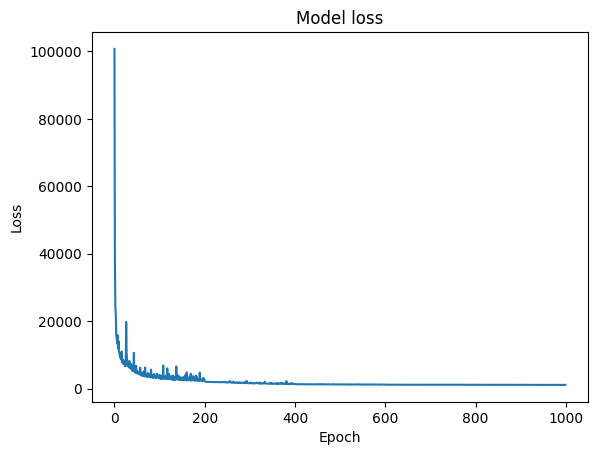

In [16]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
autoencoder_model.load_weights('autoencoder_model.hdf5')


input_s_test=x_test[0:x_test.shape[0]//2]
input_c_test=x_test[x_test.shape[0]//2:]
decode_result=autoencoder_model.predict([input_s_test,input_c_test])
#print(decode_result.shape)
decode_s, decode_c=decode_result[...,0:3],decode_result[...,3:6]

diff_s,diff_c=np.abs(decode_s-input_s_test),np.abs(decode_c-input_c_test)

###PSNR
mse=np.mean((input_c_test-decode_c)**2)
import math
max_pixel_value=255
psnr=20*math.log10(max_pixel_value/math.sqrt(mse))
print(psnr)



8/8 [==============================] - 0s 11ms/step
(250, 64, 64, 6)
75.62320714602001


In [24]:
def pixel_errors(input_s,input_c,decode_s,decode_c):
    see_spixel=np.sqrt(np.mean(np.square(255*(input_s-decode_s))))
    see_cpixel=np.sqrt(np.mean(np.square(255*(input_c-decode_c))))
    return see_spixel,see_cpixel

def pixel_histogram(diff_s,diff_c):
    diff_sflat=diff_s.flatten()
    diff_cflat=diff_c.flatten()
    
    fig=plt.figure(figsize=(15,5))
    a=fig.add_subplot(1,2,1)
    
    imgplot=plt.hist(255*diff_cflat,100,density=1,alpha=0.75,facecolor='blue')
    a.set_title('Distribution of error in the cover image')
    plt.axis([0,250,0,0.2])
    
    a=fig.add_subplot(1,2,2)
    
    imgplot=plt.hist(255*diff_sflat,100,density=1,alpha=0.75,facecolor='blue')
    a.set_title('Distribution of error in the secret image')
    plt.axis([0,250,0,0.2])
    
    plt.show()

In [25]:
s_error,c_error=pixel_errors(input_s_test,input_c_test,decode_s,decode_c)
print("Secret image error per pixel [0,255]:", s_error)
print("Contain image error per pixel [0,255]:", c_error)

Secret image error per pixel [0,255]: 6.078205
Contain image error per pixel [0,255]: 10.762668


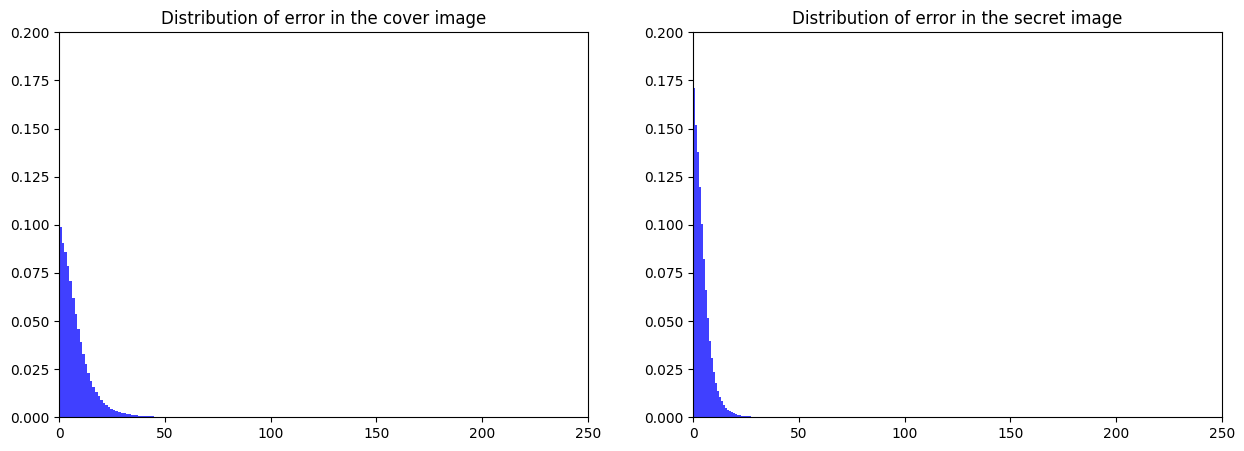

In [26]:
pixel_histogram(diff_s,diff_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

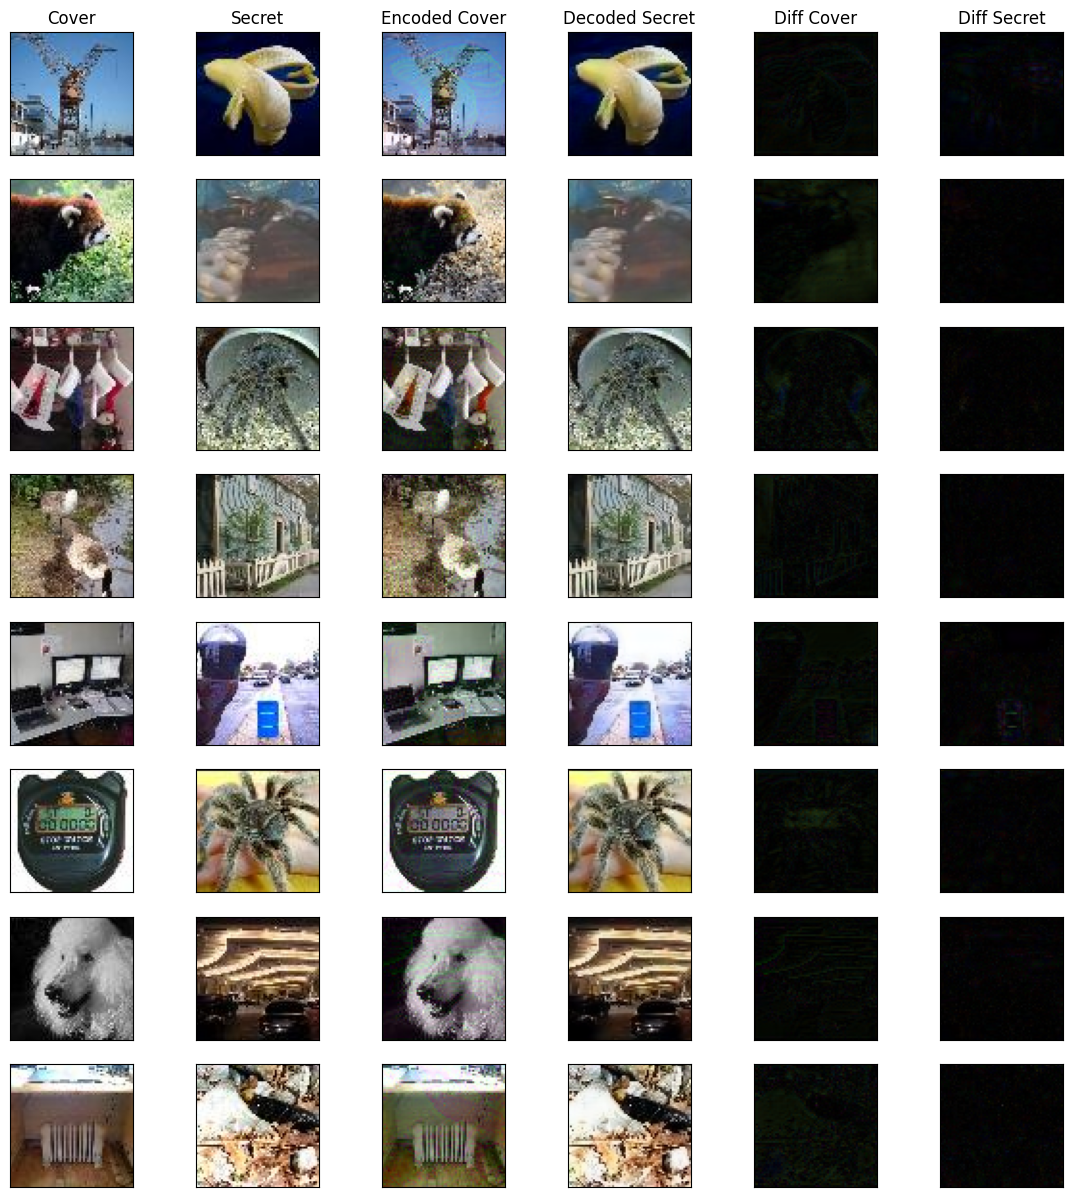

In [27]:
SHOW_DIFF=True
SHOW_GRAY=False
ENHANCE=1
n=8

def rgb2gray(rgb):
    return np.dot(rgb[...:3],[0.299,0.587,0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False,title=None):
    ax=plt.subplot(n_rows,n_col,idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14,15))
rand_indx=[random.randint(0, 250) for x in range(n)]

for i,idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    show_image(input_c_test[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    show_image(input_s_test[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(decode_c[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    show_image(decode_s[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
    if SHOW_DIFF:
        show_image(np.multiply(diff_c[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        show_image(np.multiply(diff_s[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()